# PathFinding Graph Analysis


## Configuration

In [1]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'

# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True

# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

## Checking for missing packages

In [2]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])
        
# This is to exit cells without error tracebacks (cosmetic purpose)
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Creating the required environment (skip if already done)

Running the following cell will create a file graphs.yml that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.

In [3]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas
  - statsmodels

Writing graphs.yml


### Environment Creation
To create the environment, open the terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
conda env create -f graphs.yml
After running this command you have to activate the environment (Linux/MacOS: conda activate graphs, Windows: activate graphs) and then reopen the notebook in that environment.

## Main Part

### Imports and directory information

In [1]:
import os
import cv2
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import glob
import scipy.cluster.vq as clusters
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#from sklearn.preprocessing import normalize
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import LinearSegmentedColormap
import time

In [2]:
OG_DATA_PATH = './'

condition = 'Single' # Single, Dyadic, SingleC
DATA_PATH = './Data {}/'.format(condition)
LAB_DATA_PATH = "D:/StefanSpaRe/DataBackUp/seahavenlab/"
LAB_DATA_PATH += condition.lower() + '/';
#DATA_PATH = LAB_DATA_PATH # Comment out when not in lab

# print(LAB_DATA_PATH);
RESSOURCES_PATH = './Ressources/'
#houselist 
house_file = RESSOURCES_PATH + 'building_collider_list.csv'
try:
    houselist = pd.read_csv(house_file)
except:
    print('HouseList could not be loaded!')

PROCESSED_DATA_PATH = './Results/' + condition + '/'
PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)

PROCESSED_GRAPH_PATH = './Results/' + condition + '/Graphs/'
PROCESSED_GRAPH_FOLDER = sorted([f for f in os.listdir(PROCESSED_GRAPH_PATH) if not f.startswith('.')], key=str.lower)

# Extracting all subject IDs from the data folder
# Getting the Folder without hidden files in ascending order 
DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)

subIDs = []
for sub in DATA_FOLDER:
    if sub[0].isdigit():
        subIDs.append(int(sub[0:4]))
    else:
        pass
subIDs = np.unique(subIDs)

#subIDs = subIDs[:3]
#subIDs = [1023] # remove to do for all subIDs
print(subIDs)

[1004 1005 1008 1010 1011 1013 1017 1018 1019 1021 1022 1023 1054 1055
 1056 1057 1058 1068 1069 1072 1073 1074 1075 1077 1079 1080]


In [28]:
PROCESSED_DATA_FOLDER

['1010_interpolation_df.csv',
 '1010_SingleCPathfinding_Final.json',
 '1019_interpolation_df.csv',
 '1019_SingleCPathfinding_Final.json',
 '1056_interpolation_df.csv',
 '1056_SingleCPathfinding_Final.json',
 '1068_interpolation_df.csv',
 '1068_SingleCPathfinding_Final.json',
 '1072_interpolation_df.csv',
 '1072_SingleCPathfinding_Final.json',
 '1073_interpolation_df.csv',
 '1073_SingleCPathfinding_Final.json',
 '1075_interpolation_df.csv',
 '1075_SingleCPathfinding_Final.json',
 '1077_interpolation_df.csv',
 '1077_SingleCPathfinding_Final.json',
 '1079_interpolation_df.csv',
 '1079_SingleCPathfinding_Final.json',
 '1080_interpolation_df.csv',
 '1080_SingleCPathfinding_Final.json',
 'A_Path_Stats.csv',
 'B_Path_Stats.csv',
 'Graphs',
 'SingleC_Performance_Analysis.csv',
 'Subject_Data.csv']

In [5]:
dests_A = ["Windmill-TaskBuilding_10_1", "TaskBuilding_41", "TaskBuilding_39", "TaskBuilding_7", \
          "Building_186", "TaskBuilding_29", "TaskBuilding_1", "TaskBuilding_9", "TaskBuilding_4", \
          "TaskBuilding_53"]
dests_B = dests_A.copy()
dests_B.reverse()


# Node Degree Correlation Analysis

# Paths Which Cross Triangulated Regions

In [4]:
import Ressources.TransformHelper as TransformHelper
import pickle
from matplotlib.colors import ListedColormap
from skimage.transform.pyramids import pyramid_expand as expand
import math

green = [0.40,0.80,0.42]
blue = [0.27,0.38,0.99]
yellow = [0.96,0.73,0.23]
darkblue = [0.18, 0.19, 0.69]
lightyellow = [0.9763, 0.9831, 0.0538] 
grey = [0.75,0.75,0.75]
white = [1,1,1]

def save_to_disk(data, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)
def load_from_disk(filepath):
    with open(filepath, 'rb') as file:
        data = pickle.load(file)
        return data
# External data for mapping 
transform_infos = load_from_disk("./Ressources/map_image_transform_infos.pickle")
transform_matrix = transform_infos["perspective_transform_matrix"]

white_bg_img = cv2.imread("./ressources/map_white.png")


In [5]:
def path_crossed_triangulation(path_df):
    
    crossed = False
    # transform coordinates from path_df
    gazes = TransformHelper.apply_perspective_transform_matrix(transform_matrix,
                                                                img_size=(4096,4096),
                                                                dataframe=path_df,
                                                                df_x_name="HMD_x",
                                                                df_y_name="HMD_z",
                                                                transform_x_name="transformed_HMD_x",
                                                                transform_y_name="transformed_HMD_y")
    
    hmdPositions = list(zip(path_df['HMD_x'], path_df['HMD_z']));
    
    # Round up each of hmdPositions

    hmdPositions = [(round(x), round(z)) for (x,z) in hmdPositions];
    
    Locations = np.load("./Results/Graphs/TriangulationLocations.npy")
    
    # 1 for all visited locations, 2 for 1 rich club house visible, etc. 
    # so subtract to make 1 correspond to 1 rich cl
    Locations = Locations - 1.0

    # Assume grid is 2x2 matrix
    triang_coeffs = []
    for gaze_idx in range(len(gazes)-1):
        x = round(gazes.transformed_HMD_x[gaze_idx]/16)
        y = round(gazes.transformed_HMD_y[gaze_idx]/16)
        
        triang_coeffs.append(Locations[y,x]);
    
    crossed = [sum(t >= num_bldgs for t in triang_coeffs) / len(triang_coeffs) for num_bldgs in [0,1,2]]
    
    return crossed, gazes


In [19]:
OG_DATA_PATH = './'

condition = 'SingleC' # Single, Dyadic, SingleC
DATA_PATH = './Data {}/'.format(condition)
LAB_DATA_PATH = "D:/StefanSpaRe/DataBackUp/seahavenlab/"
LAB_DATA_PATH += condition.lower() + '/';
#DATA_PATH = LAB_DATA_PATH # Comment out when not in lab

# print(LAB_DATA_PATH);
RESSOURCES_PATH = './Ressources/'
#houselist 
house_file = RESSOURCES_PATH + 'building_collider_list.csv'
try:
    houselist = pd.read_csv(house_file)
except:
    print('HouseList could not be loaded!')

PROCESSED_DATA_PATH = './Results/' + condition + '/'
PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)

PROCESSED_GRAPH_PATH = './Results/' + condition + '/Graphs/'
PROCESSED_GRAPH_FOLDER = sorted([f for f in os.listdir(PROCESSED_GRAPH_PATH) if not f.startswith('.')], key=str.lower)

# Extracting all subject IDs from the data folder
# Getting the Folder without hidden files in ascending order 
DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)

subIDs = []
for sub in DATA_FOLDER:
    if sub[0].isdigit():
        subIDs.append(int(sub[0:4]))
    else:
        pass
subIDs = np.unique(subIDs)

#subIDs = subIDs[:3]
#subIDs = [1023] # remove to do for all subIDs
print(subIDs)

[1010 1019 1056 1068 1072 1073 1075 1077 1079 1080]


In [20]:
perf_df = pd.read_csv(PROCESSED_DATA_PATH + condition + '_Performance_Analysis.csv');

num_bldgs_cols = ['VisibleBuildings0', 'VisibleBuildings1', 'VisibleBuildings2+'];
paths_crossed_cols = ['SubjectID', 'PathNum', 'Condition', 'Success'] + num_bldgs_cols;
paths_crossed = pd.DataFrame(columns=paths_crossed_cols);

gazes_sub = {}
for idx, subject in enumerate(subIDs):
    try:
        int_df = pd.read_csv(PROCESSED_DATA_PATH + str(subject) + '_interpolation_df.csv');
    except:
        print('Interpolation df for subject ' + str(subject) + ' not found');
    
    print('\nStarting subject {}/{}: {}\n'.format(idx+1, len(subIDs), subject))
    subject_perf = perf_df.loc[perf_df.SubjectID == subject]
    gazes = []
    for i in range(1,10):
        path_df = int_df[int_df.PathNumber == i].reset_index(drop=True);
        
        crossed_pctgs, gazes_i = path_crossed_triangulation(path_df);
        
        gazes.append(gazes_i)
        success = list(subject_perf["P"+str(i)+":Success"])[0];
        
        paths_crossed_dict = {
            'SubjectID' : subject,
            'PathNum' : i,
            'Condition' : list(subject_perf['Condition'])[0],
            'Success' : success
        }
        crossed_pctg_dict = {num_bldgs:pctg for (num_bldgs,pctg) in zip(num_bldgs_cols,crossed_pctgs)}
        paths_crossed_dict.update(crossed_pctg_dict)
        paths_crossed = paths_crossed.append(paths_crossed_dict, ignore_index = True)
        
    
    gazes_sub[subject] = gazes;

print("Done!")


Starting subject 1/10: 1010

Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 901/901 [00:00<00:00, 5388.80it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 516/516 [00:00<00:00, 5964.45it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 3347/3347 [00:00<00:00, 6811.42it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1179/1179 [00:00<00:00, 4709.16it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1823/1823 [00:00<00:00, 4735.44it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 2637/2637 [00:00<00:00, 5462.28it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 372/372 [00:00<00:00, 5567.18it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1385/1385 [00:00<00:00, 5485.10it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 3065/3065 [00:00<00:00, 5988.19it/s]



Starting subject 2/10: 1019

Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1011/1011 [00:00<00:00, 5823.38it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 7100.77it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 367/367 [00:00<00:00, 5154.59it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 634/634 [00:00<00:00, 5727.07it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 707/707 [00:00<00:00, 6542.09it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 877/877 [00:00<00:00, 3053.42it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 3342.11it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 511/511 [00:00<00:00, 4401.69it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 806/806 [00:00<00:00, 5130.38it/s]



Starting subject 3/10: 1056

Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 5111.24it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 771/771 [00:00<00:00, 6563.88it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 315/315 [00:00<00:00, 8646.18it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 778/778 [00:00<00:00, 6169.77it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 2090/2090 [00:00<00:00, 5662.15it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 612/612 [00:00<00:00, 7694.98it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 394/394 [00:00<00:00, 5647.97it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 2847/2847 [00:00<00:00, 6597.67it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 440/440 [00:00<00:00, 6377.12it/s]



Starting subject 4/10: 1068

Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1257/1257 [00:00<00:00, 7107.08it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 498/498 [00:00<00:00, 7176.08it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 5831.34it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 769/769 [00:00<00:00, 7502.08it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 2171/2171 [00:00<00:00, 6760.37it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 412/412 [00:00<00:00, 7351.73it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 590/590 [00:00<00:00, 6460.59it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 855/855 [00:00<00:00, 6195.02it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 3266/3266 [00:00<00:00, 5617.40it/s]



Starting subject 5/10: 1072

Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 848/848 [00:00<00:00, 6255.04it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 566/566 [00:00<00:00, 4651.85it/s]

Calculating Perspective Transform for DataFrame...

100%|██████████████████████████████████████████████████████████████████████████████| 443/443 [00:00<00:00, 5105.66it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 5318.32it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 2684/2684 [00:00<00:00, 4747.92it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 680/680 [00:00<00:00, 5794.65it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 3408.46it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 762/762 [00:00<00:00, 3692.63it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1279/1279 [00:00<00:00, 4749.83it/s]



Starting subject 6/10: 1073

Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 2821/2821 [00:00<00:00, 4454.00it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 2418/2418 [00:00<00:00, 3061.56it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 2893/2893 [00:00<00:00, 5548.27it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1548/1548 [00:00<00:00, 5135.83it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1549/1549 [00:00<00:00, 4159.47it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1157/1157 [00:00<00:00, 5986.95it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 3074/3074 [00:00<00:00, 4961.57it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1347/1347 [00:00<00:00, 4228.92it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 4380/4380 [00:00<00:00, 6380.13it/s]



Starting subject 7/10: 1075

Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 462/462 [00:00<00:00, 5581.27it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 410/410 [00:00<00:00, 5555.37it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 4783.27it/s]

Calculating Perspective Transform for DataFrame...



100%|██████████████████████████████████████████████████████████████████████████████| 549/549 [00:00<00:00, 6475.90it/s]

Calculating Perspective Transform for DataFrame...



100%|██████████████████████████████████████████████████████████████████████████████| 508/508 [00:00<00:00, 6288.57it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 595/595 [00:00<00:00, 6415.04it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1592/1592 [00:00<00:00, 7161.25it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 449/449 [00:00<00:00, 6256.12it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 328/328 [00:00<00:00, 6069.74it/s]



Starting subject 8/10: 1077

Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 661/661 [00:00<00:00, 5344.96it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 2424/2424 [00:00<00:00, 5208.26it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 279/279 [00:00<00:00, 5848.04it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 3349/3349 [00:00<00:00, 6306.37it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 2025/2025 [00:00<00:00, 6435.34it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 941/941 [00:00<00:00, 7139.05it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 245/245 [00:00<00:00, 5110.02it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1950/1950 [00:00<00:00, 5706.95it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 805/805 [00:00<00:00, 7039.15it/s]



Starting subject 9/10: 1079

Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1019/1019 [00:00<00:00, 5849.17it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1202/1202 [00:00<00:00, 6389.14it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 5133.63it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 593/593 [00:00<00:00, 3865.17it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 750/750 [00:00<00:00, 6114.03it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 525/525 [00:00<00:00, 6050.69it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1819/1819 [00:00<00:00, 6941.05it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1843/1843 [00:00<00:00, 6999.28it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1098/1098 [00:00<00:00, 6186.05it/s]



Starting subject 10/10: 1080

Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 1086/1086 [00:00<00:00, 7429.13it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 537/537 [00:00<00:00, 7185.14it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 9586.03it/s]

Calculating Perspective Transform for DataFrame...

100%|████████████████████████████████████████████████████████████████████████████| 2527/2527 [00:00<00:00, 7317.37it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 2088/2088 [00:00<00:00, 6736.68it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 633/633 [00:00<00:00, 4031.26it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 278/278 [00:00<00:00, 4835.39it/s]


Calculating Perspective Transform for DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 740/740 [00:00<00:00, 3295.59it/s]


Calculating Perspective Transform for DataFrame...


100%|████████████████████████████████████████████████████████████████████████████| 2224/2224 [00:00<00:00, 6271.09it/s]


Done!


In [15]:
paths_crossed

,SubjectID,PathNum,Condition,Success,VisibleBuildings0,VisibleBuildings1,VisibleBuildings2+
0,1004,1,A,True,1.000000,0.596639,0.552941
1,1004,2,A,True,0.977654,0.893855,0.871508
2,1004,3,A,True,1.000000,0.904321,0.833333
3,1004,4,A,True,0.984733,0.778626,0.666031
4,1004,5,A,True,1.000000,0.871134,0.716495
...,...,...,...,...,...,...,...
139,1074,5,B,True,1.000000,0.904943,0.754753
140,1074,6,B,True,0.999305,0.845726,0.808200
141,1074,7,B,True,1.000000,0.976672,0.908243
142,1074,8,B,True,1.000000,0.834655,0.762174


In [21]:
PROCESSED_DATA_PATH

'./Results/SingleC/'

In [22]:
# Save to file
paths_crossed.to_csv(PROCESSED_DATA_PATH + 'Paths_Crossed_Triangulation.csv', index=False);

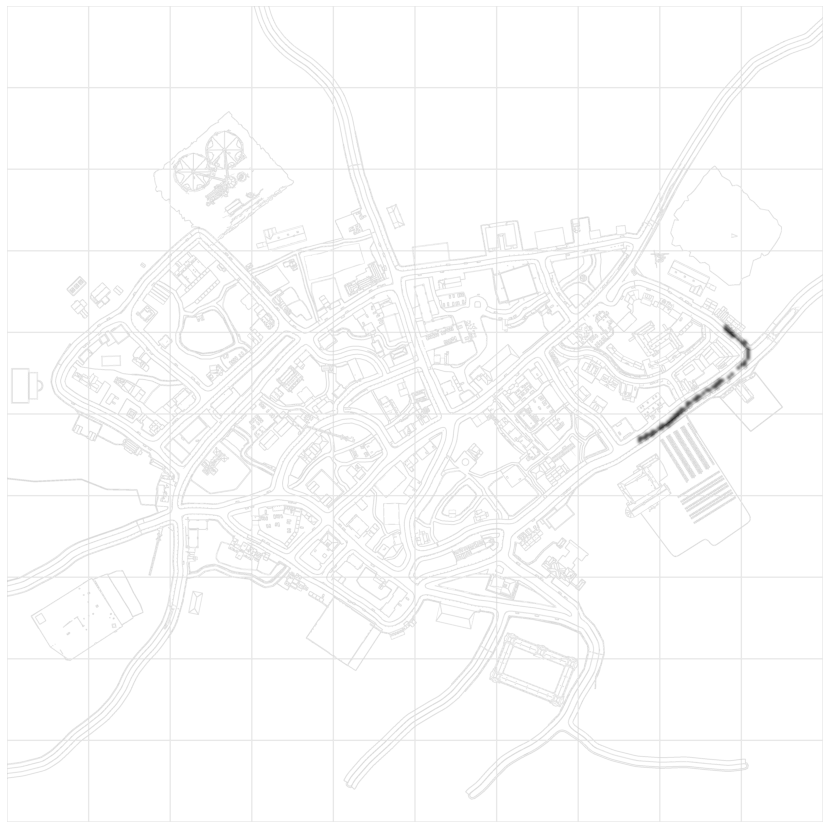

In [159]:
# Plotting the HMD locations for the paths

Locations = np.zeros((256,256))
#RichLocations = np.load('./Results/Graphs/TriangulationLocations.npy')

gazes = gazes_sub[1054]

for i in range(len(gazes)):
    current_gaze = gazes[6]
    # loop to check which location has been visited
    for gaze_idx in range(len(current_gaze)-1):

        x = round(current_gaze.transformed_HMD_x[gaze_idx]/16)
        y = round(current_gaze.transformed_HMD_y[gaze_idx]/16)

        if Locations[y,x] == 0:
            Locations[y,x] = 1.2 ** i
            Locations[y,x] = int(Locations[y,x])

Locations = expand(Locations, upscale=16)
#RichLocations = expand(RichLocations, upscale=16)

# ---------- PLOTTING ---------   

#discrete color scheme
cMap = ListedColormap([darkblue, green, lightyellow])


fig = plt.figure(figsize=(20,15))
    
ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
plt.xlim(0, 4096)
plt.ylim(0, 4096)
ax.set_frame_on(False)
plt.axis('off')


# Here, for plot visibility, I am doing a inverse Canny Edge Detection 
# to only plot the binary edge image of the map
plt.imshow(cv2.bitwise_not(cv2.Canny(white_bg_img, threshold1=30, threshold2=100)),
         aspect=ax.get_aspect(),
         extent= ax.get_xlim() + ax.get_ylim(),
         zorder=1, alpha=0.3)

plt.gray()



triang = plt.imshow(np.ceil(Locations.max())-Locations)


# triang2 = plt.imshow(RichLocations,
#            alpha = 1,
#            cmap=cMap)

# cbar = plt.colorbar(triang2)
# cbar.ax.get_yaxis().set_ticks([])

# for j, lab in enumerate(['0','1','>2']):
#     cbar.ax.text(1,
#                  (2 * j + 1)/2.0 ,
#                  lab,
#                  ha='center',
#                  va='center',
#                  fontsize=fontsize)
    
# cbar.set_label('Visible Rich CLub Houses', size=fontsize+5, labelpad=20)
    


   


### Findings:

* No clear relation between how much of the triangulated regions are covered on a path and success
    * Successes spread out over all crossing percentages
        * True in all conditions
    * Failures concentrated in the middle (0.4 - 0.6) in Single
        * This observation doesn't change in different conditions (A or B)
            * A, 0.511/0.180, 0.419/0.172
            * B, 0.504/0.142, 0.395/0.134
        * Not many failures in Dyadic and SingleC to see distribution

* No clear consistent correlation between pctg of triangulated region covered and time
* Success below a certain threshold crossed is higher the lower the threshold is
* Success above a certain threshold crossed is higher the higher the threshold is

Overall Success: 0.662
Overall Failure Distribution:
VisibleBuildings1: 	Mean:0.638	SD:0.164
VisibleBuildings2+: 	Mean:0.537	SD:0.165
Overall Success Distribution:
VisibleBuildings1: 	Mean:0.627	SD:0.321
VisibleBuildings2+: 	Mean:0.533	SD:0.315

VisibleBuildings0
	0.1 -	Agreement: 0.662	Success above: 0.662	Success below: 0.000
	0.25 -	Agreement: 0.662	Success above: 0.662	Success below: 0.000
	0.33 -	Agreement: 0.662	Success above: 0.662	Success below: 0.000
	0.5 -	Agreement: 0.662	Success above: 0.662	Success below: 0.000
	0.67 -	Agreement: 0.662	Success above: 0.662	Success below: 0.000
	0.75 -	Agreement: 0.662	Success above: 0.662	Success below: 0.000
	0.8 -	Agreement: 0.662	Success above: 0.662	Success below: 0.000

VisibleBuildings1
	0.1 -	Agreement: 0.573	Success above: 0.629	Success below: 1.000
	0.25 -	Agreement: 0.547	Success above: 0.618	Success below: 1.000
	0.33 -	Agreement: 0.534	Success above: 0.615	Success below: 0.941
	0.5 -	Agreement: 0.543	Success above: 0.638	Succes

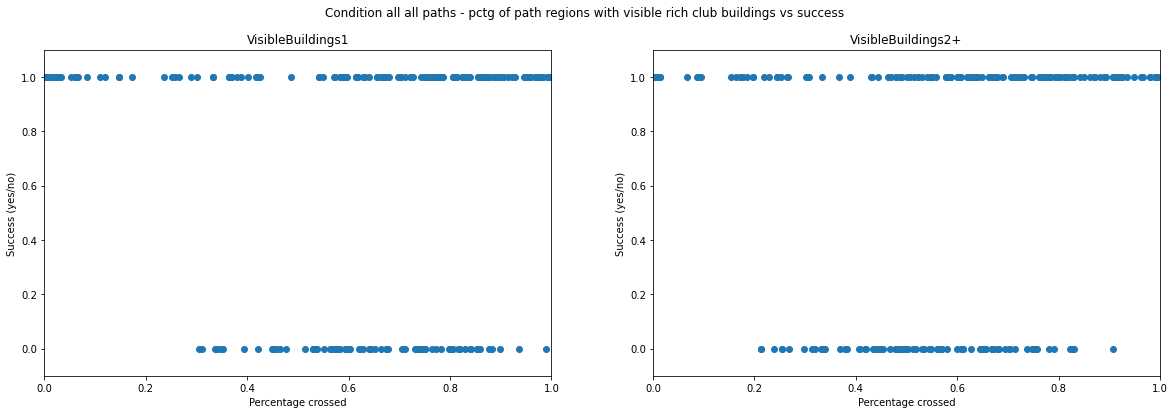

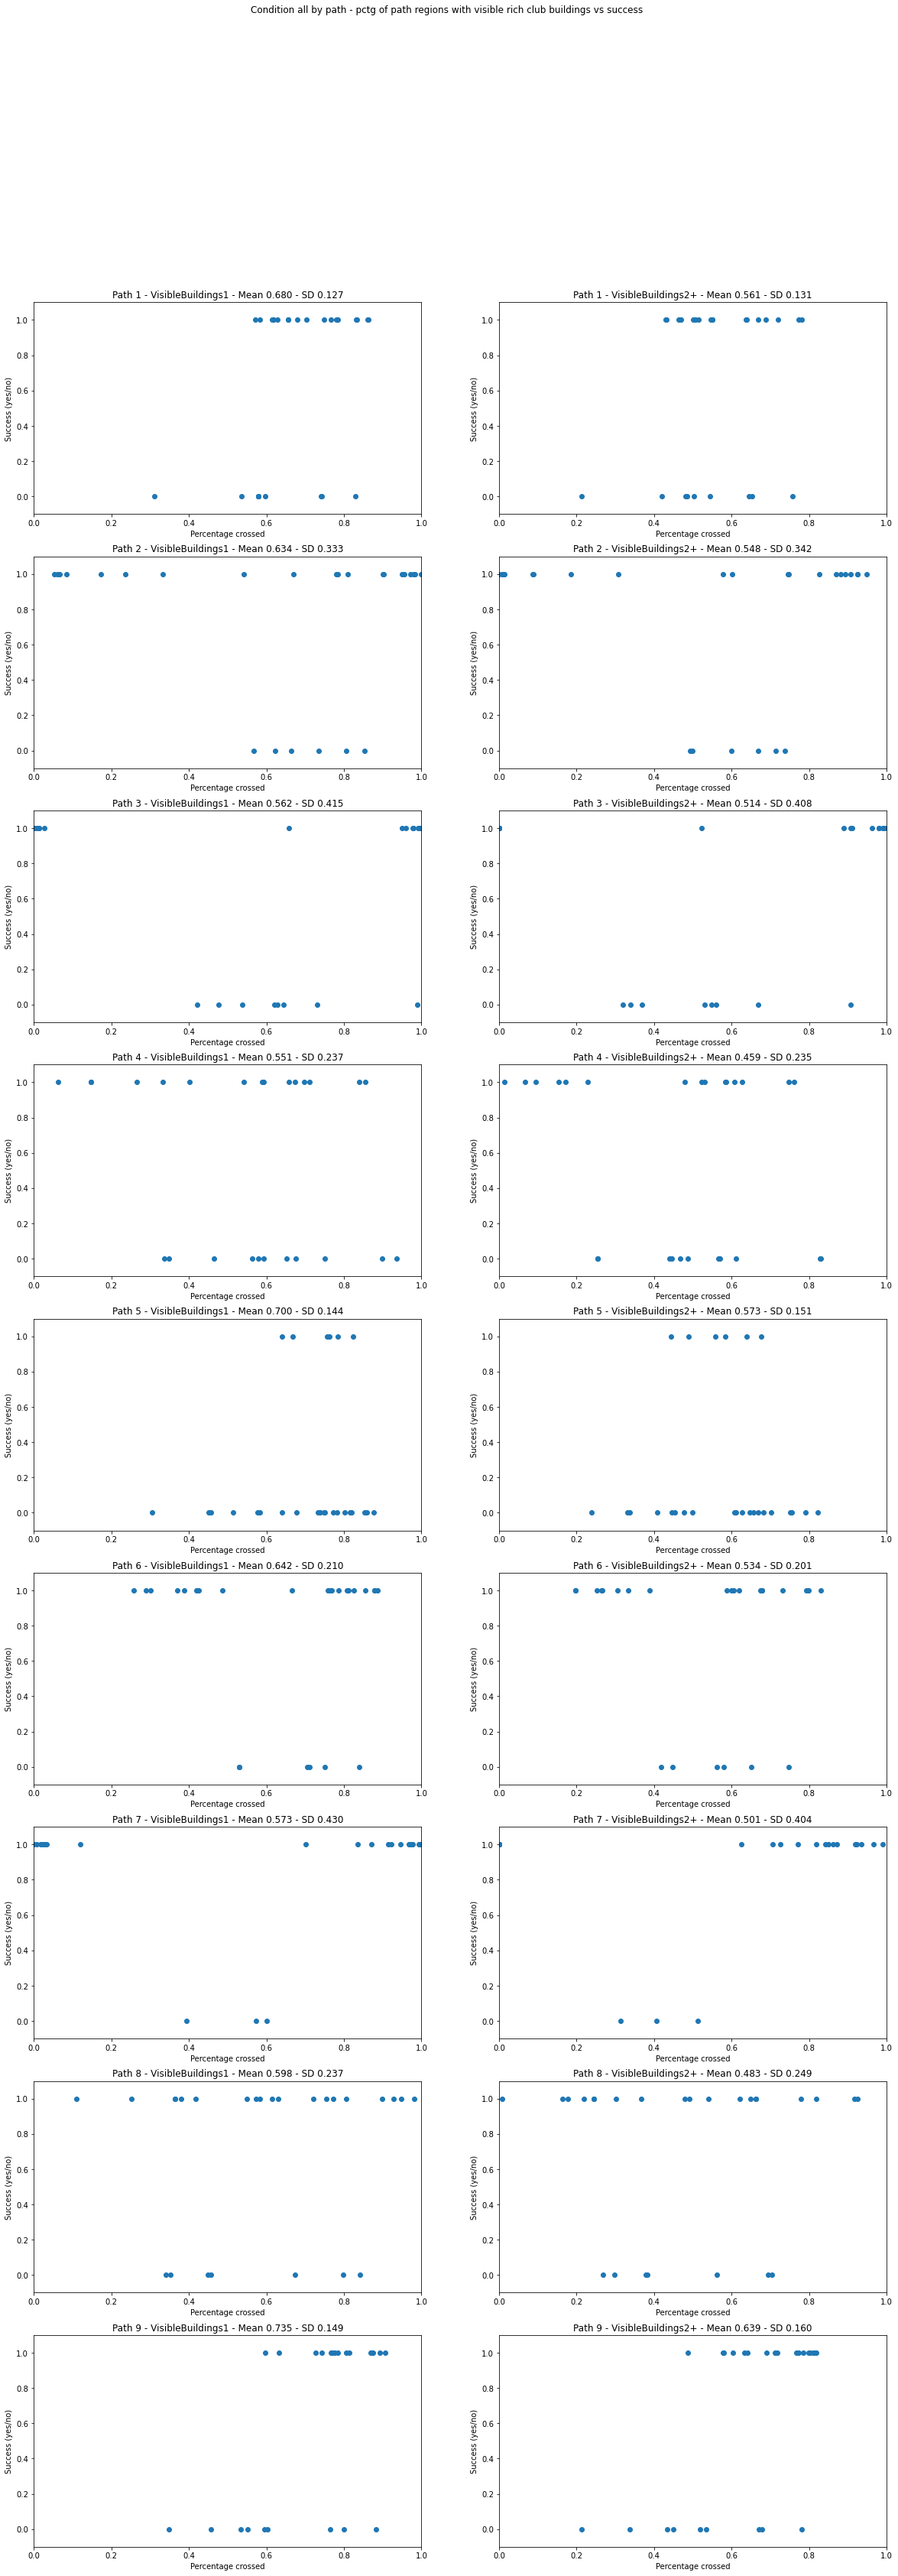

In [12]:
# Analysis of percentage of rich club regions crossed vs. path success - Single

num_bldgs_cols = ['VisibleBuildings0', 'VisibleBuildings1', 'VisibleBuildings2+'];

condition = 'all' # A, B, all
paths_crossed_all = pd.read_csv('./Results/Single/Paths_Crossed_Triangulation.csv');

# Filter by condition
if condition is not "all": 
    paths_crossed = paths_crossed_all[paths_crossed_all.Condition == condition]
else:
    paths_crossed = paths_crossed_all

paths_failed = paths_crossed[paths_crossed.Success == False]
paths_succeeded = paths_crossed[paths_crossed.Success]

cross_thresholds = [0.10, 0.25, 0.33, 0.5, 0.67, 0.75, 0.80]
cross_thresh_cols = [("Crossed " + str(ct)) for ct in cross_thresholds]

cross_mean = paths_crossed.groupby(by=["PathNum"]).mean()
cross_std = paths_crossed.groupby(by=["PathNum"]).std()

succ_mean_1 = paths_succeeded['VisibleBuildings1'].mean()
succ_std_1 = paths_succeeded['VisibleBuildings1'].std()

succ_mean_2 = paths_succeeded['VisibleBuildings2+'].mean()
succ_std_2 = paths_succeeded['VisibleBuildings2+'].std()

fail_mean_1 = paths_failed['VisibleBuildings1'].mean()
fail_std_1 = paths_failed['VisibleBuildings1'].std()

fail_mean_2 = paths_failed['VisibleBuildings2+'].mean()
fail_std_2 = paths_failed['VisibleBuildings2+'].std()

# Get successes of all paths
success = list(paths_crossed.Success)
print("Overall Success: {0:0.3f}".format(sum(success)/len(success)))
print("Overall Failure Distribution:")
print("VisibleBuildings1: \tMean:{0:0.3f}\tSD:{1:0.3f}".format(fail_mean_1, fail_std_1))
print("VisibleBuildings2+: \tMean:{0:0.3f}\tSD:{1:0.3f}".format(fail_mean_2, fail_std_2))
print("Overall Success Distribution:")
print("VisibleBuildings1: \tMean:{0:0.3f}\tSD:{1:0.3f}".format(succ_mean_1, succ_std_1))
print("VisibleBuildings2+: \tMean:{0:0.3f}\tSD:{1:0.3f}".format(succ_mean_2, succ_std_2))

# Loop through the number of possible rich club buildings visible (0, 1, 2+)
for colid, col in enumerate(num_bldgs_cols):
    print("\n"+col)
    
    # Check if region percentages for number of buildings crosses certain thresholds
    for thresh in cross_thresholds:
        
        pctgs = list(paths_crossed[col])
        
        # Get those paths that have higher region percentage than the current threshold
        paths_crossed_sup = paths_crossed[paths_crossed[col] > thresh];
        paths_crossed_sub = paths_crossed[paths_crossed[col] < thresh];
        
        # Get the successes for the paths that cross the threshold
        sup_success = list(paths_crossed_sup.Success);
        sub_success = list(paths_crossed_sub.Success);
        
        # Percentage of successes above the given threshold
        success_above_thresh = sum(sup_success) / len(sup_success)
        success_below_thresh = 0;
        if len(sub_success) > 0: success_below_thresh = sum(sub_success) / len(sub_success)
        
        # Check whether successes correspond to those paths where the region percentage crosses the threshold
        agreement = [(pctg > thresh) == succ for (pctg, succ) in zip(pctgs, success)] 
        
        agreement_pctg = sum(agreement) / len(agreement)
        print("\t{0} -\tAgreement: {1:0.3f}\tSuccess above: {2:0.3f}\tSuccess below: {3:0.3f}".format(thresh,\
                                                                                                      agreement_pctg,\
                                                                                                      success_above_thresh,\
                                                                                                     success_below_thresh))
    

# Plot region percentages against successes for all paths
fig, axs = plt.subplots(1,2,figsize=(20,6))
fig.suptitle("Condition {} all paths - pctg of path regions with visible rich club buildings vs success".format(condition))
for idx, ax in enumerate(axs):
    pctgs = list(paths_crossed[num_bldgs_cols[idx+1]]);
    succ = list(map(int,list(paths_crossed.Success)));
    
    ax.scatter(pctgs, succ);
    ax.set_title(num_bldgs_cols[idx+1])
    ax.set_xlabel("Percentage crossed")
    ax.set_ylabel("Success (yes/no)")
    ax.set_xlim([0,1])
    ax.set_ylim([-0.1, 1.1])

# Plot region percentages against successes per path
fig2, axs2 = plt.subplots(9,2,figsize=(20,6*9))
fig2.suptitle("Condition {} by path - pctg of path regions with visible rich club buildings vs success".format(condition))
for pathnum, axrow in enumerate(axs2):
    paths_crossed_sub = paths_crossed[paths_crossed.PathNum == pathnum+1]
    if pathnum+1 == 7: temp_df = paths_crossed_sub
    for num_bldgs, ax in enumerate(axrow):
        col = num_bldgs_cols[num_bldgs+1]
        pctgs = list(paths_crossed_sub[col]);
        succ = list(map(int,list(paths_crossed_sub.Success)));

        ax.scatter(pctgs, succ);
        ax.set_title("Path {0} - {1} - Mean {2:0.3f} - SD {3:0.3f}".format(pathnum+1,col,\
                                                                          cross_mean[col][pathnum+1],\
                                                                          cross_std[col][pathnum+1]))
        ax.set_xlabel("Percentage crossed")
        ax.set_ylabel("Success (yes/no)")
        ax.set_xlim([0,1])
        ax.set_ylim([-0.1, 1.1])
    
plt.show()

Overall Success: 0.889
Overall Failure Distribution:
VisibleBuildings1: 	Mean:0.585	SD:0.159
VisibleBuildings2+: 	Mean:0.500	SD:0.158
Overall Success Distribution:
VisibleBuildings1: 	Mean:0.594	SD:0.323
VisibleBuildings2+: 	Mean:0.503	SD:0.319

VisibleBuildings0
	0.1 -	Agreement: 0.889	Success above: 0.889	Success below: 0.000
	0.25 -	Agreement: 0.889	Success above: 0.889	Success below: 0.000
	0.33 -	Agreement: 0.889	Success above: 0.889	Success below: 0.000
	0.5 -	Agreement: 0.889	Success above: 0.889	Success below: 0.000
	0.67 -	Agreement: 0.889	Success above: 0.889	Success below: 0.000
	0.75 -	Agreement: 0.889	Success above: 0.889	Success below: 0.000
	0.8 -	Agreement: 0.889	Success above: 0.889	Success below: 0.000

VisibleBuildings1
	0.1 -	Agreement: 0.750	Success above: 0.871	Success below: 1.000
	0.25 -	Agreement: 0.750	Success above: 0.871	Success below: 1.000
	0.33 -	Agreement: 0.722	Success above: 0.867	Success below: 1.000
	0.5 -	Agreement: 0.583	Success above: 0.870	Succes

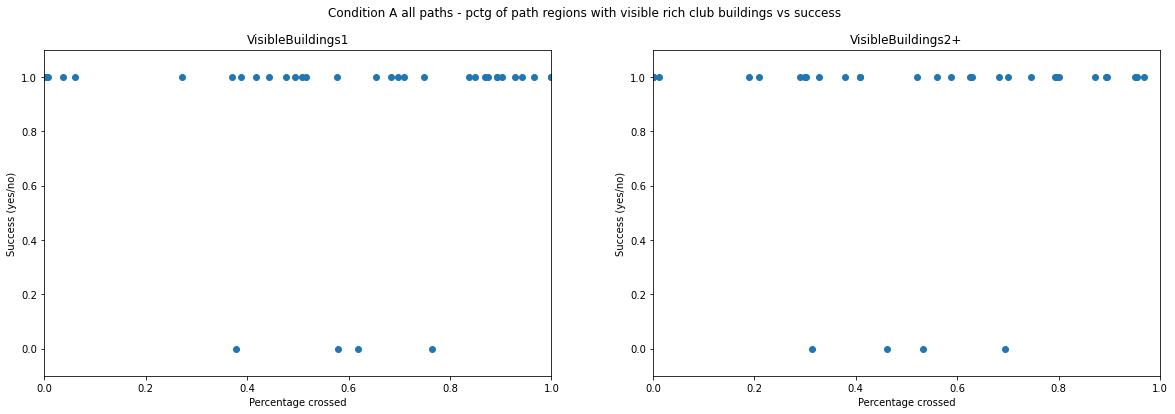

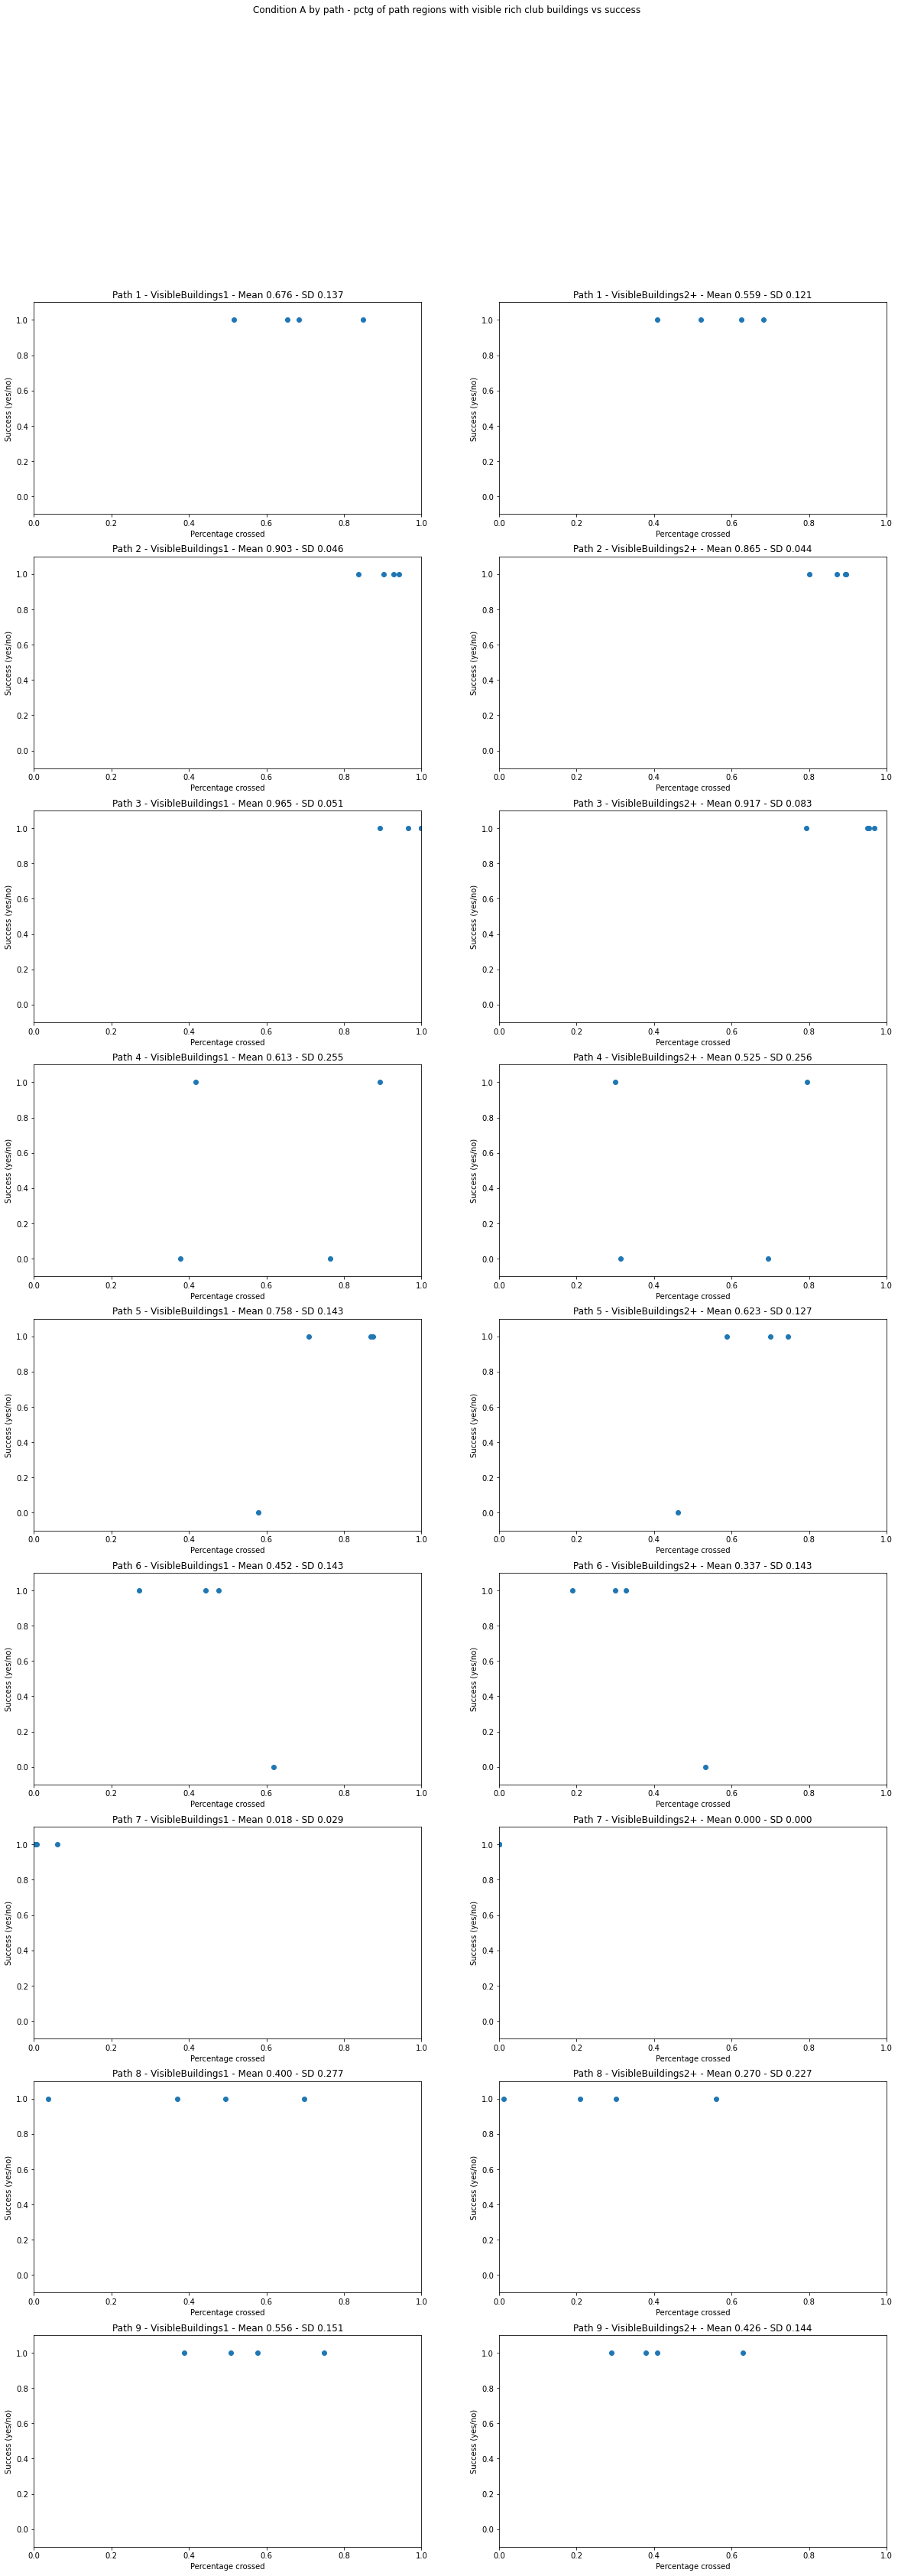

In [18]:
# Analysis of percentage of rich club regions crossed vs. path success - Dyadic

condition = 'A' # A, B
paths_crossed_all = pd.read_csv('./Results/Dyadic/Paths_Crossed_Triangulation.csv');
dyadic_pair_map = {
    '1021' : '1022',
    '1023' : '1013',
    '1005' : '1055',
    '1074' : '1069',
    '1008' : '1058',
    '1054' : '1004',
    '1011' : '1017',
    '1018' : '1057'
}
paths_crossed_lead = paths_crossed_all.loc[paths_crossed_all['SubjectID'].isin(dyadic_pair_map.keys())].reset_index(drop=True)


# Filter by condition
paths_crossed = paths_crossed_lead[paths_crossed_lead.Condition == condition]

paths_failed = paths_crossed[paths_crossed.Success == False]
paths_succeeded = paths_crossed[paths_crossed.Success]

cross_thresholds = [0.10, 0.25, 0.33, 0.5, 0.67, 0.75, 0.80]
cross_thresh_cols = [("Crossed " + str(ct)) for ct in cross_thresholds]

cross_mean = paths_crossed.groupby(by=["PathNum"]).mean()
cross_std = paths_crossed.groupby(by=["PathNum"]).std()

succ_mean_1 = paths_succeeded['VisibleBuildings1'].mean()
succ_std_1 = paths_succeeded['VisibleBuildings1'].std()

succ_mean_2 = paths_succeeded['VisibleBuildings2+'].mean()
succ_std_2 = paths_succeeded['VisibleBuildings2+'].std()

fail_mean_1 = paths_failed['VisibleBuildings1'].mean()
fail_std_1 = paths_failed['VisibleBuildings1'].std()

fail_mean_2 = paths_failed['VisibleBuildings2+'].mean()
fail_std_2 = paths_failed['VisibleBuildings2+'].std()

# Get successes of all paths
success = list(paths_crossed.Success)
print("Overall Success: {0:0.3f}".format(sum(success)/len(success)))
print("Overall Failure Distribution:")
print("VisibleBuildings1: \tMean:{0:0.3f}\tSD:{1:0.3f}".format(fail_mean_1, fail_std_1))
print("VisibleBuildings2+: \tMean:{0:0.3f}\tSD:{1:0.3f}".format(fail_mean_2, fail_std_2))
print("Overall Success Distribution:")
print("VisibleBuildings1: \tMean:{0:0.3f}\tSD:{1:0.3f}".format(succ_mean_1, succ_std_1))
print("VisibleBuildings2+: \tMean:{0:0.3f}\tSD:{1:0.3f}".format(succ_mean_2, succ_std_2))


# Loop through the number of possible rich club buildings visible (0, 1, 2+)
for colid, col in enumerate(num_bldgs_cols):
    print("\n"+col)
    
    # Check if region percentages for number of buildings crosses certain thresholds
    for thresh in cross_thresholds:
        
        pctgs = list(paths_crossed[col])
        
        paths_crossed_sup = paths_crossed[paths_crossed[col] > thresh];
        sup_success = list(paths_crossed_sup.Success);
        
        paths_crossed_sub = paths_crossed[paths_crossed[col] < thresh];
        sub_success = list(paths_crossed_sub.Success);
        
        success_below_thresh = 0
        if len(sub_success) > 0: 
            success_below_thresh = sum(sub_success) / len(sub_success)
            
        success_above_thresh = sum(sup_success) / len(sup_success)
        
        # Check whether successes correspond to those paths where the region percentage crosses the threshold
        agreement = [(pctg > thresh) == succ for (pctg, succ) in zip(pctgs, success)] 
        
        agreement_pctg = sum(agreement) / len(agreement)
        print("\t{0} -\tAgreement: {1:0.3f}\tSuccess above: {2:0.3f}\tSuccess below: {3:0.3f}".format(thresh,\
                                                                                                      agreement_pctg,\
                                                                                                      success_above_thresh,\
                                                                                                     success_below_thresh))

    

# Plot region percentages against successes for all paths
fig, axs = plt.subplots(1,2,figsize=(20,6))
fig.suptitle("Condition {} all paths - pctg of path regions with visible rich club buildings vs success".format(condition))
for idx, ax in enumerate(axs):
    pctgs = list(paths_crossed[num_bldgs_cols[idx+1]]);
    succ = list(map(int,list(paths_crossed.Success)));
    
    ax.scatter(pctgs, succ);
    ax.set_title(num_bldgs_cols[idx+1])
    ax.set_xlabel("Percentage crossed")
    ax.set_ylabel("Success (yes/no)")
    ax.set_xlim([0,1])
    ax.set_ylim([-0.1, 1.1])

# Plot region percentages against successes per path
fig2, axs2 = plt.subplots(9,2,figsize=(20,6*9))
fig2.suptitle("Condition {} by path - pctg of path regions with visible rich club buildings vs success".format(condition))
for pathnum, axrow in enumerate(axs2):
    paths_crossed_sub = paths_crossed[paths_crossed.PathNum == pathnum+1]
    if pathnum+1 == 7: temp_df = paths_crossed_sub
    for num_bldgs, ax in enumerate(axrow):
        col = num_bldgs_cols[num_bldgs+1]
        pctgs = list(paths_crossed_sub[col]);
        succ = list(map(int,list(paths_crossed_sub.Success)));

        ax.scatter(pctgs, succ);
        ax.set_title("Path {0} - {1} - Mean {2:0.3f} - SD {3:0.3f}".format(pathnum+1,col,\
                                                                          cross_mean[col][pathnum+1],\
                                                                          cross_std[col][pathnum+1]))
        ax.set_xlabel("Percentage crossed")
        ax.set_ylabel("Success (yes/no)")
        ax.set_xlim([0,1])
        ax.set_ylim([-0.1, 1.1])
    
plt.show()

Overall Success: 0.741
Overall Failure Distribution:
VisibleBuildings1: 	Mean:0.642	SD:0.148
VisibleBuildings2+: 	Mean:0.526	SD:0.136
Overall Success Distribution:
VisibleBuildings1: 	Mean:0.575	SD:0.321
VisibleBuildings2+: 	Mean:0.473	SD:0.314

VisibleBuildings0
	0.1 -	Agreement: 0.741	Success above: 0.741
	0.25 -	Agreement: 0.741	Success above: 0.741
	0.33 -	Agreement: 0.741	Success above: 0.741
	0.5 -	Agreement: 0.741	Success above: 0.741
	0.67 -	Agreement: 0.741	Success above: 0.741
	0.75 -	Agreement: 0.741	Success above: 0.741
	0.8 -	Agreement: 0.741	Success above: 0.741

VisibleBuildings1
	0.1 -	Agreement: 0.648	Success above: 0.714
	0.25 -	Agreement: 0.611	Success above: 0.702
	0.33 -	Agreement: 0.519	Success above: 0.667
	0.5 -	Agreement: 0.481	Success above: 0.676
	0.67 -	Agreement: 0.481	Success above: 0.731
	0.75 -	Agreement: 0.463	Success above: 0.789
	0.8 -	Agreement: 0.463	Success above: 0.867

VisibleBuildings2+
	0.1 -	Agreement: 0.630	Success above: 0.708
	0.25 -	Agreem

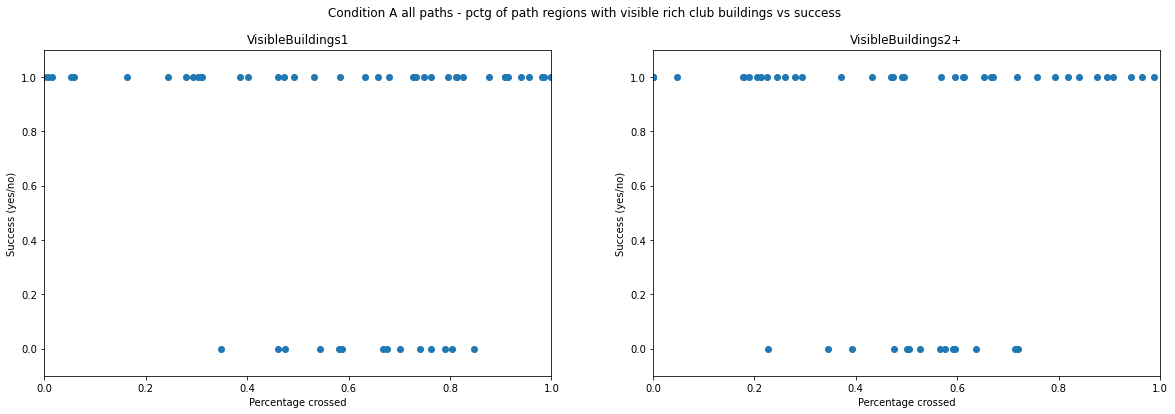

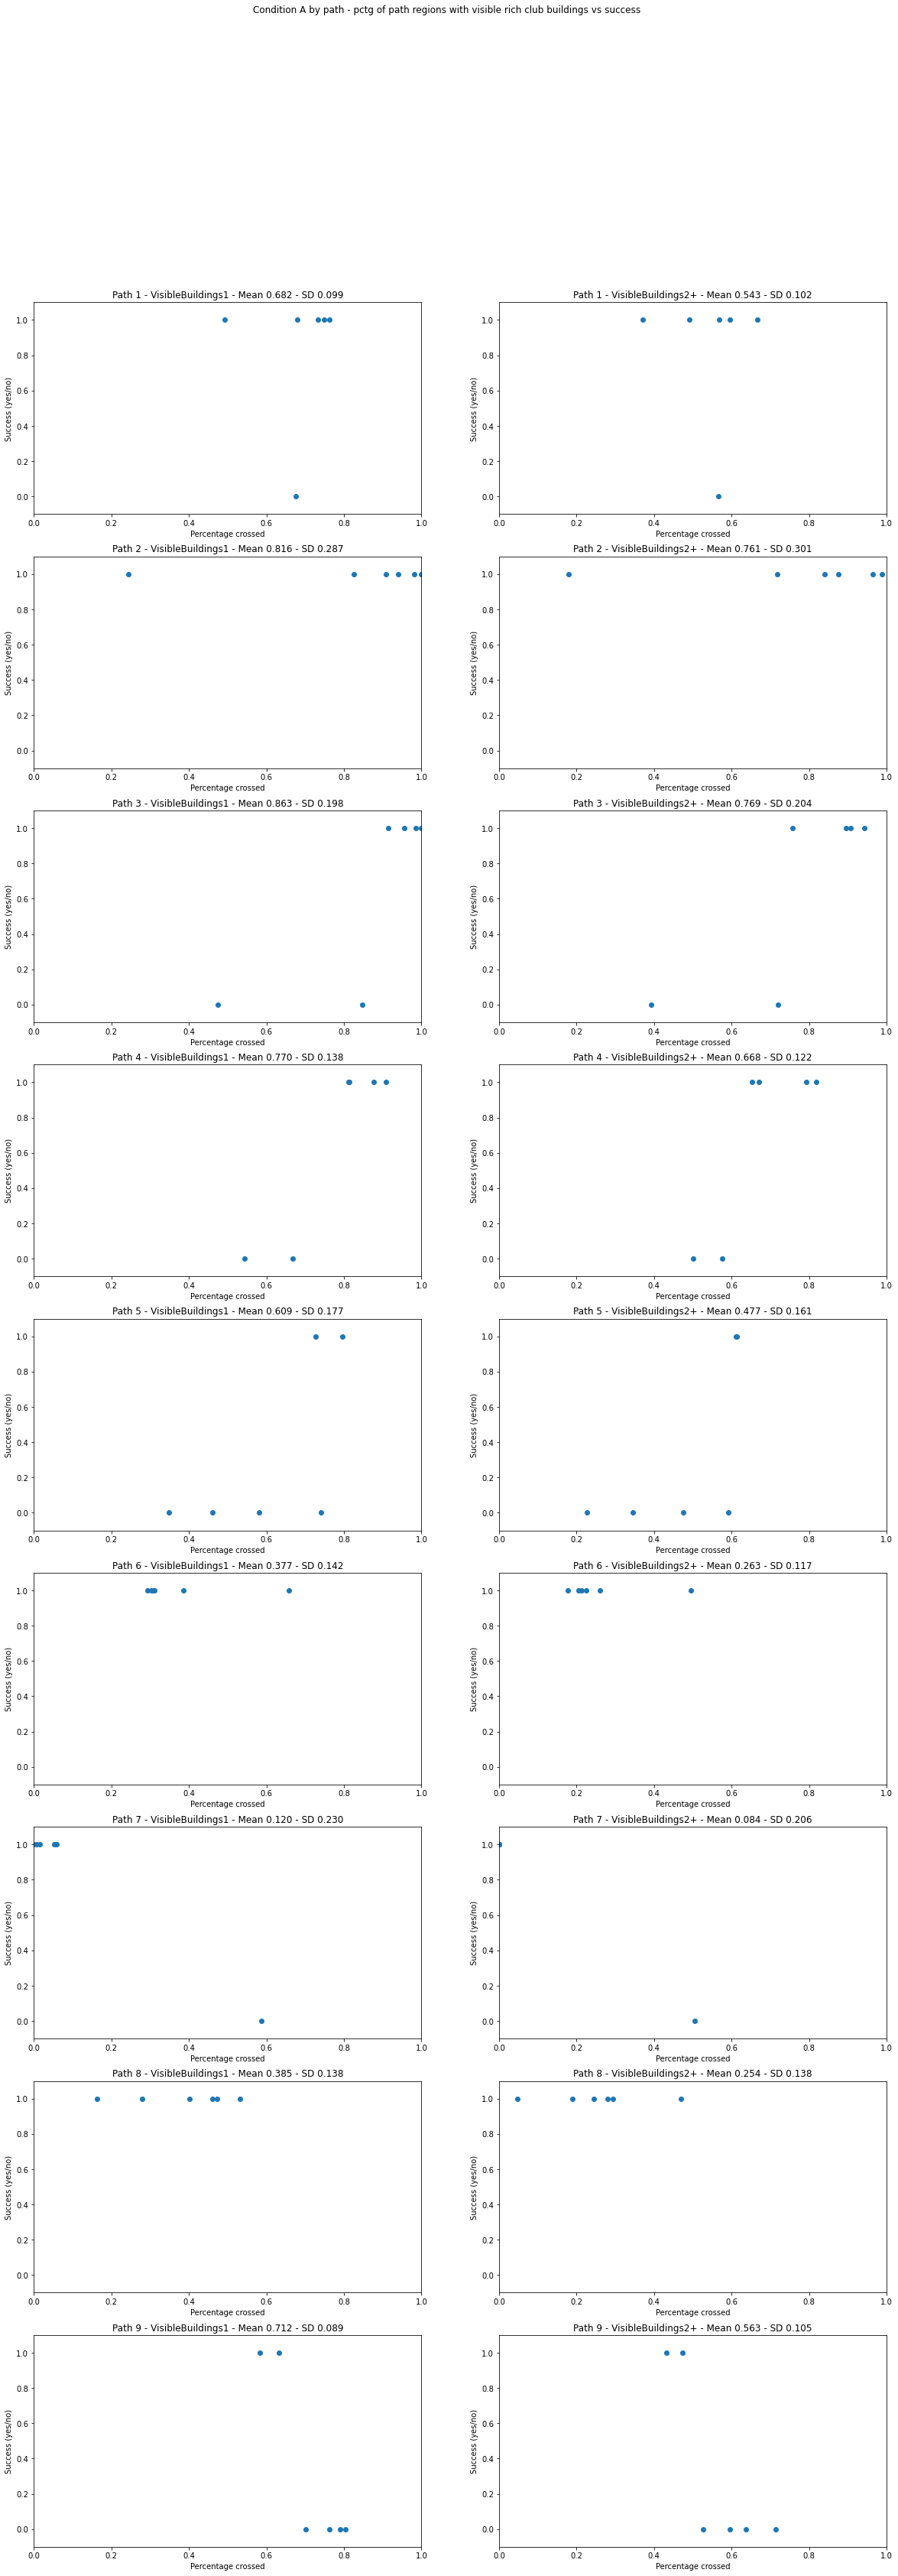

In [23]:
# Analysis of percentage of rich club regions crossed vs. path success - SingleC

condition = 'A' # A, B
paths_crossed_all = pd.read_csv('./Results/SingleC/Paths_Crossed_Triangulation.csv');

# Filter by condition
paths_crossed = paths_crossed_all[paths_crossed_all.Condition == condition]

paths_failed = paths_crossed[paths_crossed.Success == False]
paths_succeeded = paths_crossed[paths_crossed.Success]

cross_thresholds = [0.10, 0.25, 0.33, 0.5, 0.67, 0.75, 0.80]
cross_thresh_cols = [("Crossed " + str(ct)) for ct in cross_thresholds]

cross_mean = paths_crossed.groupby(by=["PathNum"]).mean()
cross_std = paths_crossed.groupby(by=["PathNum"]).std()

succ_mean_1 = paths_succeeded['VisibleBuildings1'].mean()
succ_std_1 = paths_succeeded['VisibleBuildings1'].std()

succ_mean_2 = paths_succeeded['VisibleBuildings2+'].mean()
succ_std_2 = paths_succeeded['VisibleBuildings2+'].std()

fail_mean_1 = paths_failed['VisibleBuildings1'].mean()
fail_std_1 = paths_failed['VisibleBuildings1'].std()

fail_mean_2 = paths_failed['VisibleBuildings2+'].mean()
fail_std_2 = paths_failed['VisibleBuildings2+'].std()

# Get successes of all paths
success = list(paths_crossed.Success)
print("Overall Success: {0:0.3f}".format(sum(success)/len(success)))
print("Overall Failure Distribution:")
print("VisibleBuildings1: \tMean:{0:0.3f}\tSD:{1:0.3f}".format(fail_mean_1, fail_std_1))
print("VisibleBuildings2+: \tMean:{0:0.3f}\tSD:{1:0.3f}".format(fail_mean_2, fail_std_2))
print("Overall Success Distribution:")
print("VisibleBuildings1: \tMean:{0:0.3f}\tSD:{1:0.3f}".format(succ_mean_1, succ_std_1))
print("VisibleBuildings2+: \tMean:{0:0.3f}\tSD:{1:0.3f}".format(succ_mean_2, succ_std_2))


# Loop through the number of possible rich club buildings visible (0, 1, 2+)
for colid, col in enumerate(num_bldgs_cols):
    print("\n"+col)
    
    # Check if region percentages for number of buildings crosses certain thresholds
    for thresh in cross_thresholds:
        
        pctgs = list(paths_crossed[col])
        
        # Get those paths that have higher region percentage than the current threshold
        paths_crossed_sub = paths_crossed[paths_crossed[col] > thresh];
        
        # Get the successes for the paths that cross the threshold
        sub_success = list(paths_crossed_sub.Success);
        
        # Percentage of successes above the given threshold
        success_above_thresh = sum(sub_success) / len(sub_success)
        
        # Check whether successes correspond to those paths where the region percentage crosses the threshold
        agreement = [(pctg > thresh) == succ for (pctg, succ) in zip(pctgs, success)] 
        
        agreement_pctg = sum(agreement) / len(agreement)
        print("\t{0} -\tAgreement: {1:0.3f}\tSuccess above: {2:0.3f}".format(thresh, agreement_pctg, success_above_thresh))
    

# Plot region percentages against successes for all paths
fig, axs = plt.subplots(1,2,figsize=(20,6))
fig.suptitle("Condition {} all paths - pctg of path regions with visible rich club buildings vs success".format(condition))
for idx, ax in enumerate(axs):
    pctgs = list(paths_crossed[num_bldgs_cols[idx+1]]);
    succ = list(map(int,list(paths_crossed.Success)));
    
    ax.scatter(pctgs, succ);
    ax.set_title(num_bldgs_cols[idx+1])
    ax.set_xlabel("Percentage crossed")
    ax.set_ylabel("Success (yes/no)")
    ax.set_xlim([0,1])
    ax.set_ylim([-0.1, 1.1])

# Plot region percentages against successes per path
fig2, axs2 = plt.subplots(9,2,figsize=(20,6*9))
fig2.suptitle("Condition {} by path - pctg of path regions with visible rich club buildings vs success".format(condition))
for pathnum, axrow in enumerate(axs2):
    paths_crossed_sub = paths_crossed[paths_crossed.PathNum == pathnum+1]
    if pathnum+1 == 7: temp_df = paths_crossed_sub
    for num_bldgs, ax in enumerate(axrow):
        col = num_bldgs_cols[num_bldgs+1]
        pctgs = list(paths_crossed_sub[col]);
        succ = list(map(int,list(paths_crossed_sub.Success)));

        ax.scatter(pctgs, succ);
        ax.set_title("Path {0} - {1} - Mean {2:0.3f} - SD {3:0.3f}".format(pathnum+1,col,\
                                                                          cross_mean[col][pathnum+1],\
                                                                          cross_std[col][pathnum+1]))
        ax.set_xlabel("Percentage crossed")
        ax.set_ylabel("Success (yes/no)")
        ax.set_xlim([0,1])
        ax.set_ylim([-0.1, 1.1])
    
plt.show()

C:\Users\Srinidhi\.conda\envs\graphs\lib\site-packages\numpy\lib\polynomial.py:628: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
C:\Users\Srinidhi\.conda\envs\graphs\lib\site-packages\numpy\lib\polynomial.py:628: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


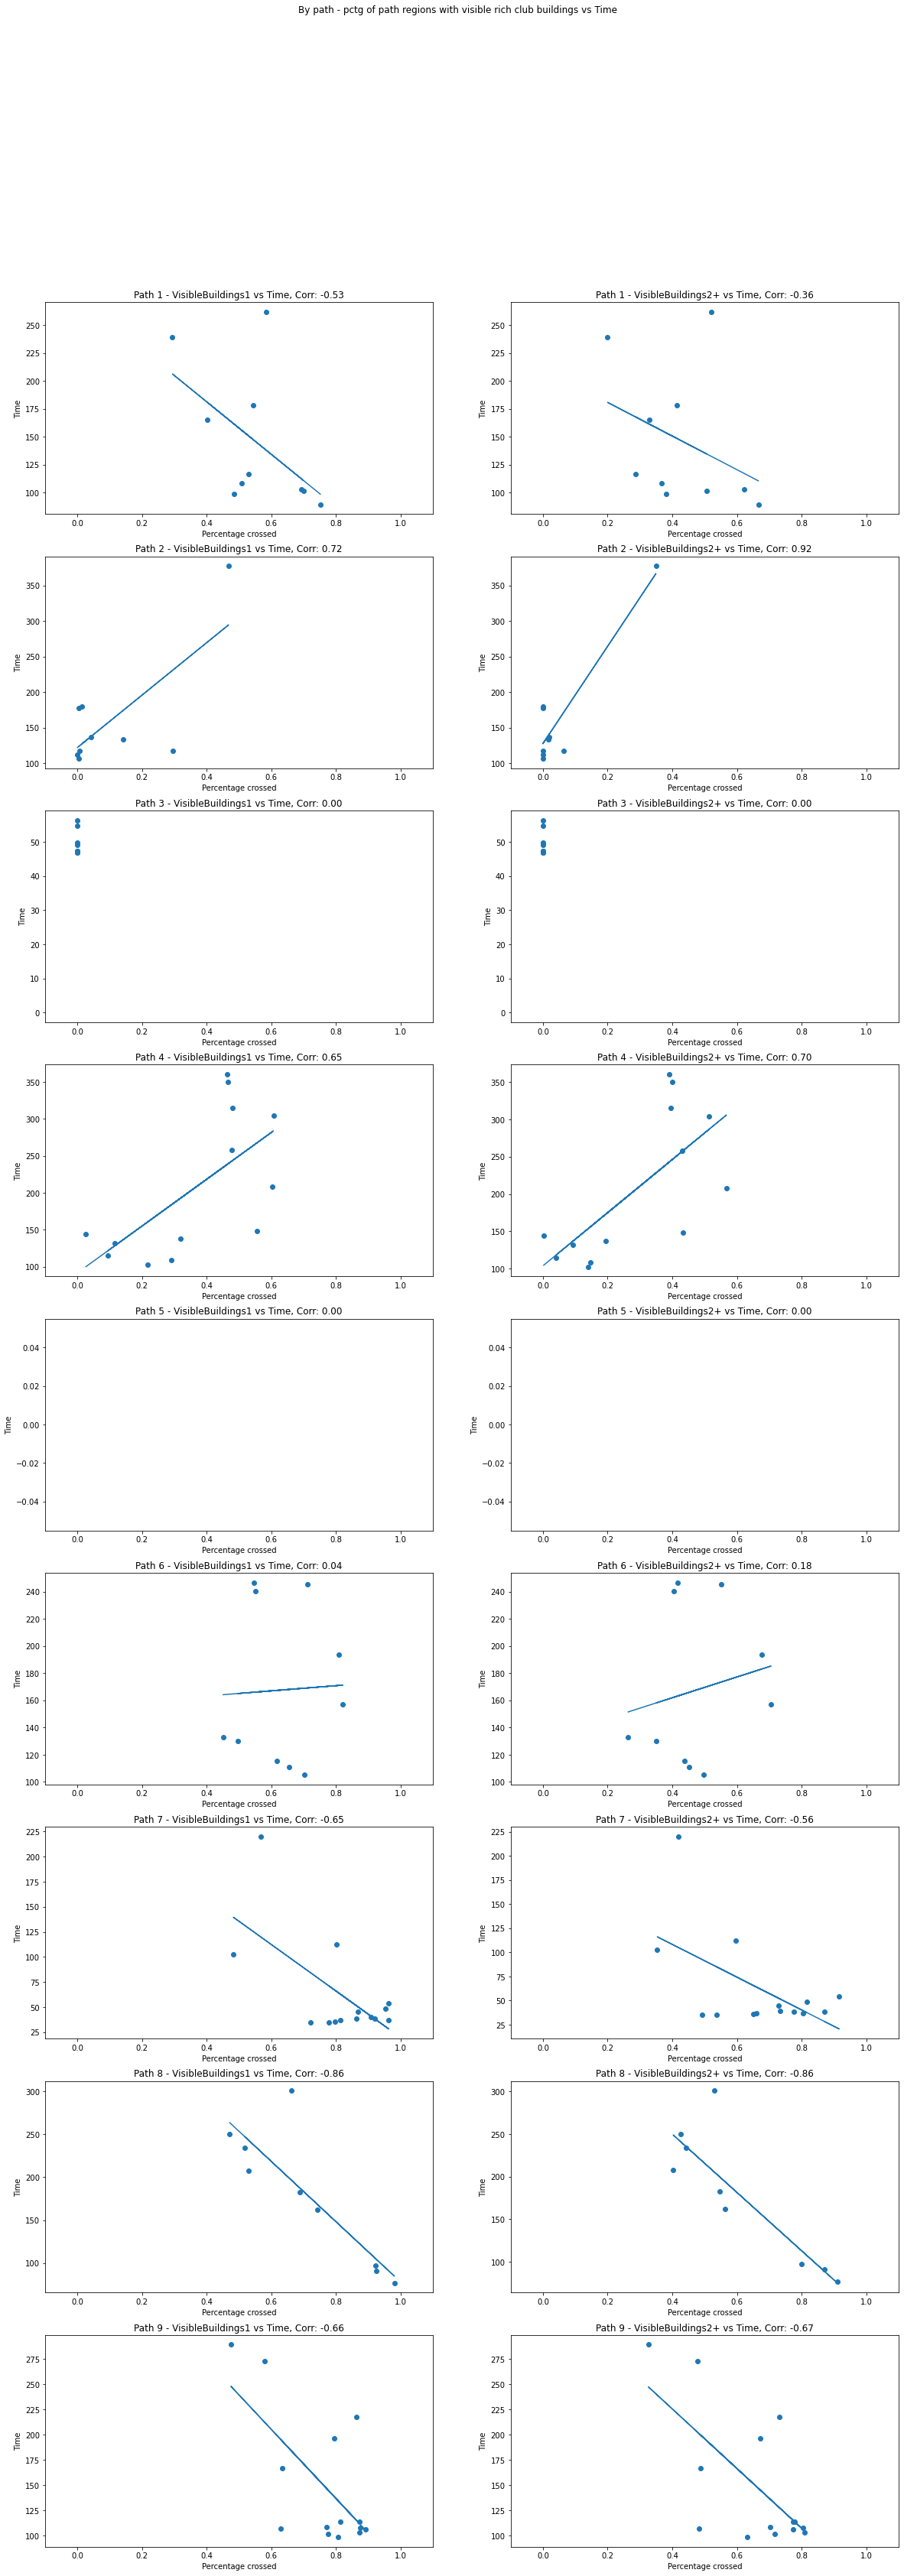

In [59]:
# Analysis of percentage of rich club regions crossed vs. other path metrics (time taken, etc.) - Single
num_bldgs_cols = ['VisibleBuildings0', 'VisibleBuildings1', 'VisibleBuildings2+'];

condition = 'B' # A, B
plot_metric = 'Time' # Time, Distance
only_success = True

paths_crossed_all = pd.read_csv('./Results/Single/Paths_Crossed_Triangulation.csv');

# Filter by condition
paths_crossed = paths_crossed_all[paths_crossed_all.Condition == condition]
perf_anal = pd.read_csv('./Results/Single/Single_Performance_Analysis.csv')

# Get the path metrics for each path from Subject Path Performance Df
path_metric_cols = ['Time', 'Distance']
path_metric_df = pd.DataFrame(index=range(len(paths_crossed)), columns=path_metric_cols);

for idx,row in paths_crossed.iterrows():
    pathnum = row.PathNum;
    subID = row.SubjectID;
    subrow = perf_anal.loc[perf_anal['SubjectID'] == subID]
    time = list(subrow['P'+str(pathnum)+':TimeSec'])[0]
    dist = list(subrow['P'+str(pathnum)+':Distance Covered'])[0]
    path_metric_df.at[idx, 'Time'] = time;
    path_metric_df.at[idx, 'Distance'] = dist;

paths_crossed_ext = paths_crossed.join(path_metric_df)

# Plot region percentages against successes per path
fig2, axs2 = plt.subplots(9,2,figsize=(20,6*9))
fig2.suptitle("By path - pctg of path regions with visible rich club buildings vs {}".format(plot_metric))
for pathnum, axrow in enumerate(axs2):
    paths_crossed_sub = paths_crossed_ext[paths_crossed_ext.PathNum == pathnum+1]
    # Comment in to check only for successes
    if only_success: paths_crossed_sub = paths_crossed_sub[paths_crossed_sub.Success];
    for num_bldgs, ax in enumerate(axrow):
        col = num_bldgs_cols[num_bldgs+1]
        pctgs = np.array(list(paths_crossed_sub[col]));
        metric = np.array(list(paths_crossed_sub[plot_metric]));
        
        corr_ = 0
        m = 0
        b = 0
        try:
            m, b = np.polyfit(pctgs, metric, 1)
            corr_ = np.corrcoef(pctgs,metric)[0,1];
        except:
            pass;
        ax.scatter(pctgs, metric);
        ax.plot(pctgs, m * pctgs + b)
        ax.set_title("Path {0} - {1} vs {2}, Corr: {3:0.2f}".format(pathnum+1,col,plot_metric,corr_))
        ax.set_xlabel("Percentage crossed")
        ax.set_ylabel(plot_metric)
        ax.set_xlim([-0.1,1.1])
        
    
plt.show()

C:\Users\Srinidhi\.conda\envs\graphs\lib\site-packages\numpy\lib\polynomial.py:628: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
C:\Users\Srinidhi\.conda\envs\graphs\lib\site-packages\numpy\lib\polynomial.py:628: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


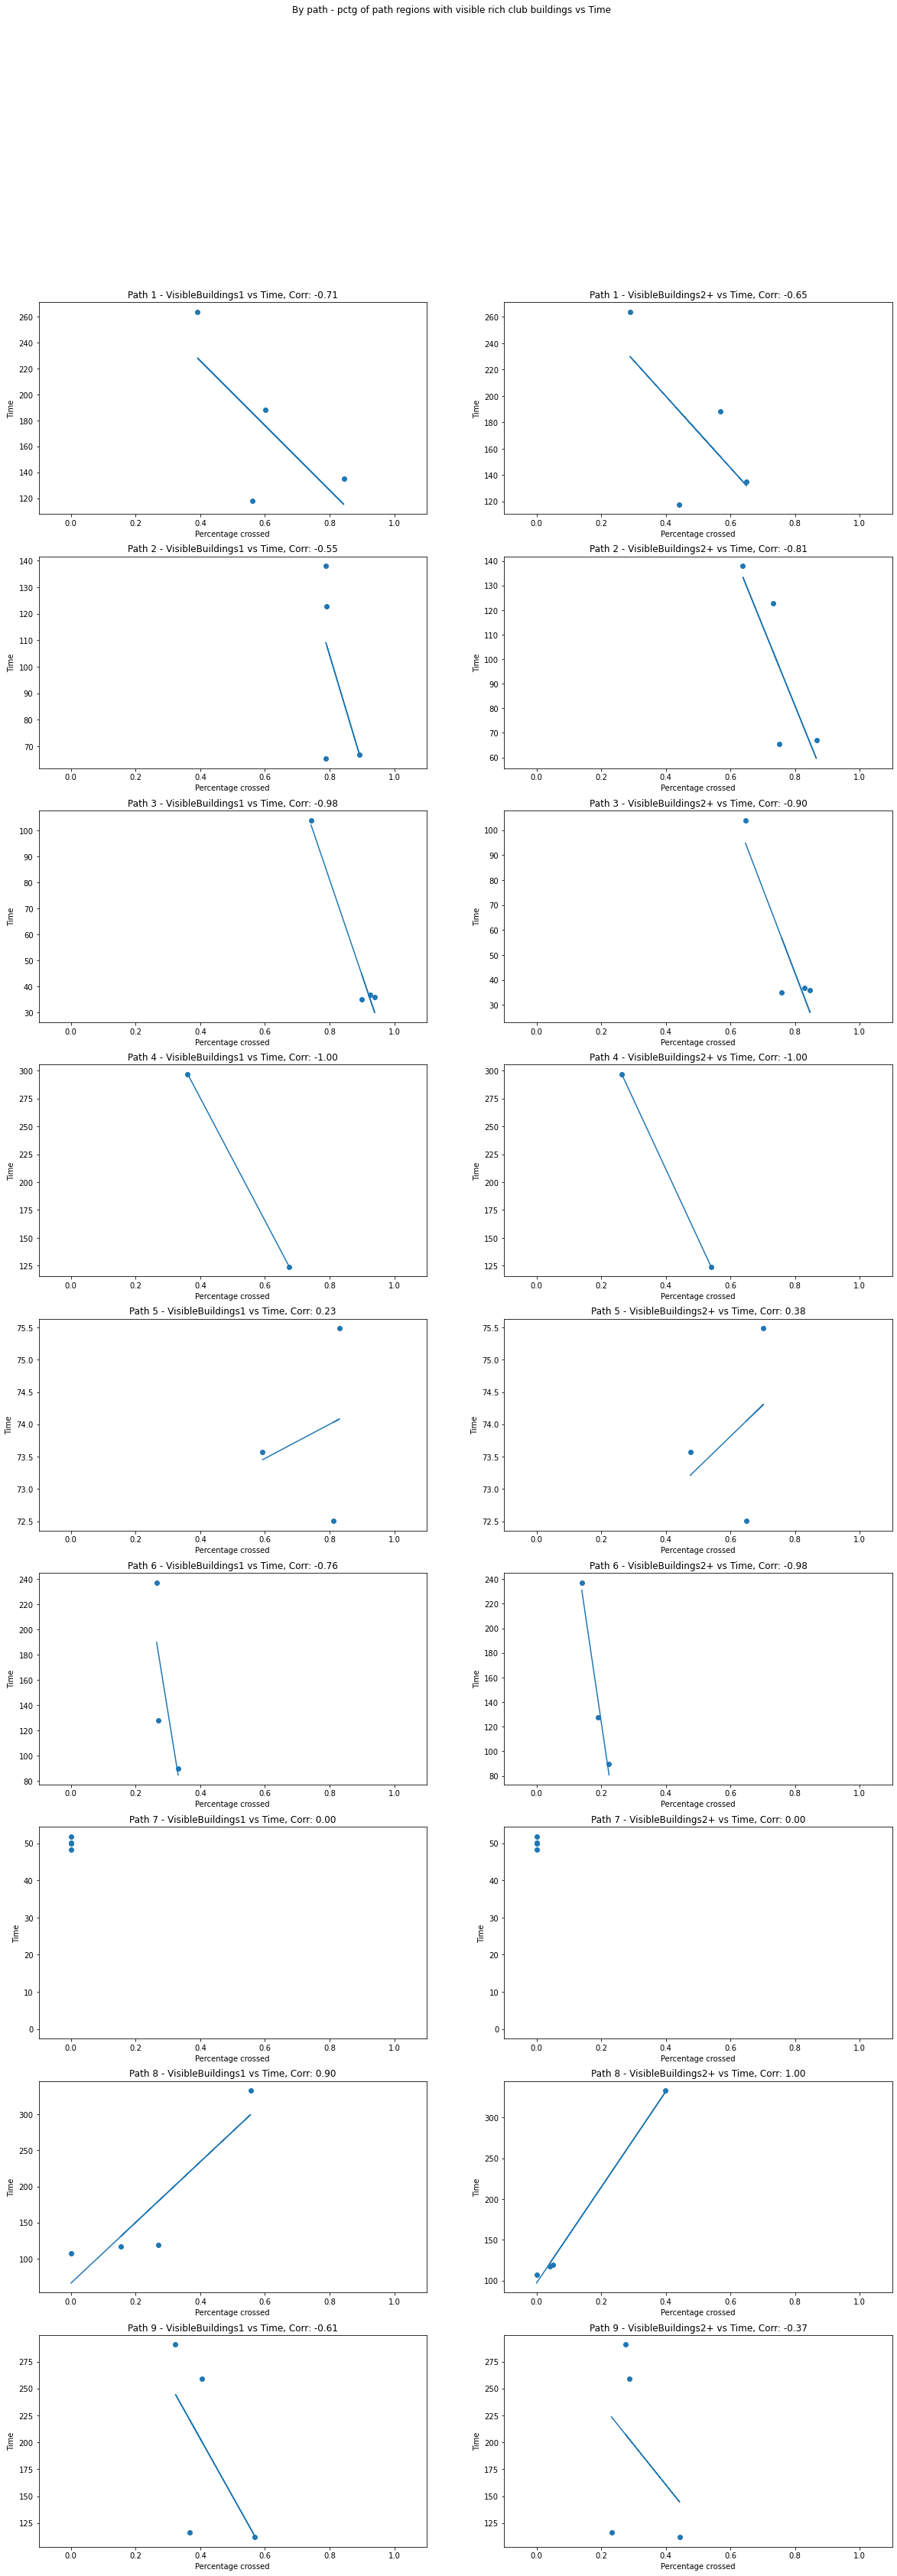

In [63]:
# Analysis of percentage of rich club regions crossed vs. other path metrics (time taken, etc.) - Dyadic
num_bldgs_cols = ['VisibleBuildings0', 'VisibleBuildings1', 'VisibleBuildings2+'];

condition = 'A' # A, B
plot_metric = 'Time' # Time, Distance
only_success = True

paths_crossed_all = pd.read_csv('./Results/Dyadic/Paths_Crossed_Triangulation.csv');
dyadic_pair_map = {
    '1021' : '1022',
    '1023' : '1013',
    '1005' : '1055',
    '1074' : '1069',
    '1008' : '1058',
    '1054' : '1004',
    '1011' : '1017',
    '1018' : '1057'
}
paths_crossed_lead = paths_crossed_all.loc[paths_crossed_all['SubjectID'].isin(dyadic_pair_map.keys())].reset_index(drop=True)


# Filter by condition
paths_crossed = paths_crossed_lead[paths_crossed_lead.Condition == condition]
perf_anal = pd.read_csv('./Results/Dyadic/Dyadic_Performance_Analysis.csv')

# Get the path metrics for each path from Subject Path Performance Df
path_metric_cols = ['Time', 'Distance']
path_metric_df = pd.DataFrame(index=range(len(paths_crossed)), columns=path_metric_cols);

for idx,row in paths_crossed.iterrows():
    pathnum = row.PathNum;
    subID = row.SubjectID;
    subrow = perf_anal.loc[perf_anal['SubjectID'] == subID]
    time = list(subrow['P'+str(pathnum)+':TimeSec'])[0]
    dist = list(subrow['P'+str(pathnum)+':Distance Covered'])[0]
    path_metric_df.at[idx, 'Time'] = time;
    path_metric_df.at[idx, 'Distance'] = dist;

paths_crossed_ext = paths_crossed.join(path_metric_df)

# Plot region percentages against successes per path
fig2, axs2 = plt.subplots(9,2,figsize=(20,6*9))
fig2.suptitle("By path - pctg of path regions with visible rich club buildings vs {}".format(plot_metric))
for pathnum, axrow in enumerate(axs2):
    paths_crossed_sub = paths_crossed_ext[paths_crossed_ext.PathNum == pathnum+1]
    # Comment in to check only for successes
    if only_success: paths_crossed_sub = paths_crossed_sub[paths_crossed_sub.Success];
    for num_bldgs, ax in enumerate(axrow):
        col = num_bldgs_cols[num_bldgs+1]
        pctgs = np.array(list(paths_crossed_sub[col]));
        metric = np.array(list(paths_crossed_sub[plot_metric]));
        
        corr_ = 0
        m = 0
        b = 0
        try:
            m, b = np.polyfit(pctgs, metric, 1)
            corr_ = np.corrcoef(pctgs,metric)[0,1];
        except:
            pass;
        ax.scatter(pctgs, metric);
        ax.plot(pctgs, m * pctgs + b)
        ax.set_title("Path {0} - {1} vs {2}, Corr: {3:0.2f}".format(pathnum+1,col,plot_metric,corr_))
        ax.set_xlabel("Percentage crossed")
        ax.set_ylabel(plot_metric)
        ax.set_xlim([-0.1,1.1])
        
    
plt.show()

C:\Users\Srinidhi\.conda\envs\graphs\lib\site-packages\numpy\lib\polynomial.py:628: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
C:\Users\Srinidhi\.conda\envs\graphs\lib\site-packages\numpy\lib\polynomial.py:628: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


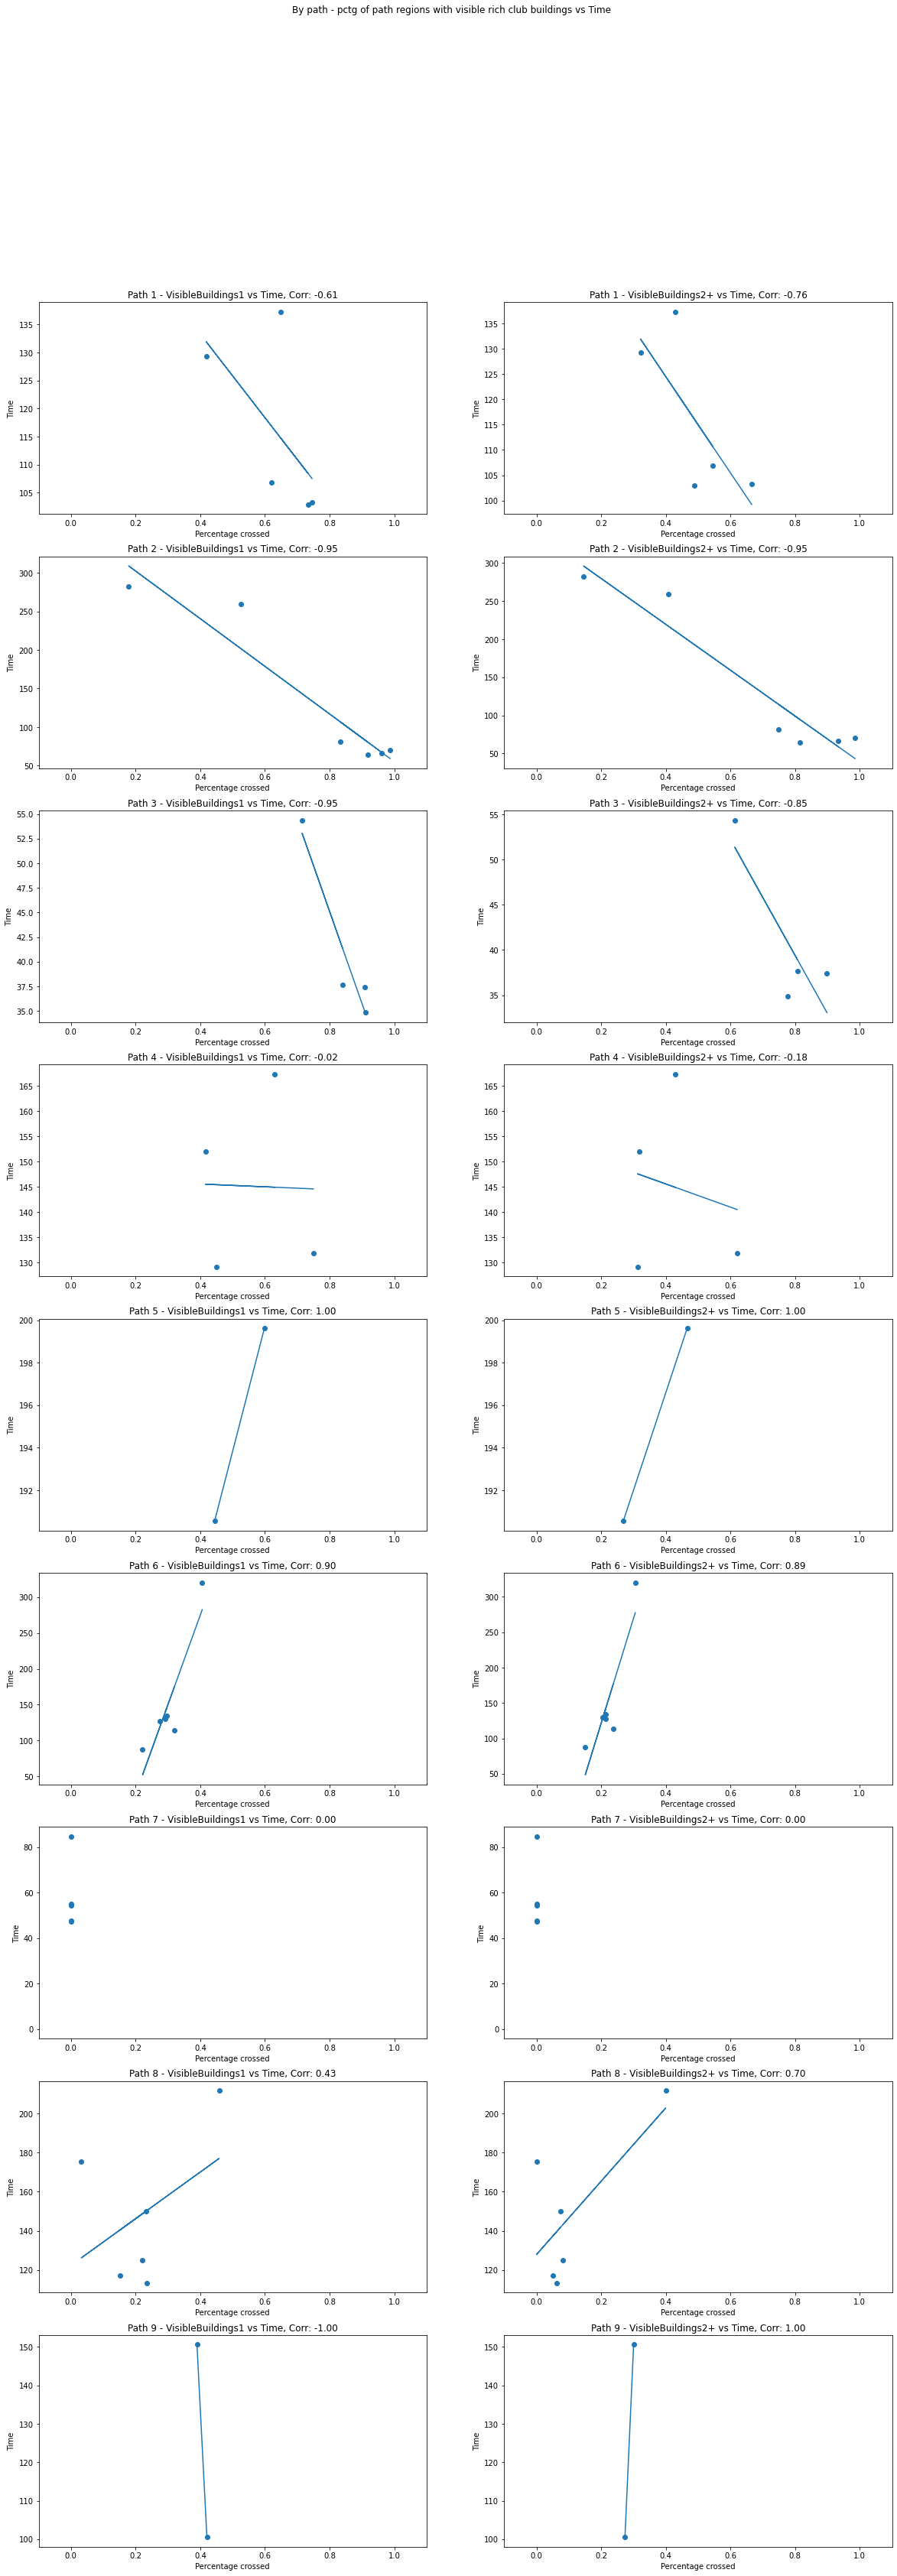

In [64]:
# Analysis of percentage of rich club regions crossed vs. other path metrics (time taken, etc.) - SingleC
num_bldgs_cols = ['VisibleBuildings0', 'VisibleBuildings1', 'VisibleBuildings2+'];

condition = 'A' # A, B
plot_metric = 'Time' # Time, Distance
only_success = True

paths_crossed_all = pd.read_csv('./Results/SingleC/Paths_Crossed_Triangulation.csv');

# Filter by condition
paths_crossed = paths_crossed_all[paths_crossed_all.Condition == condition]
perf_anal = pd.read_csv('./Results/SingleC/SingleC_Performance_Analysis.csv')

# Get the path metrics for each path from Subject Path Performance Df
path_metric_cols = ['Time', 'Distance']
path_metric_df = pd.DataFrame(index=range(len(paths_crossed)), columns=path_metric_cols);

for idx,row in paths_crossed.iterrows():
    pathnum = row.PathNum;
    subID = row.SubjectID;
    subrow = perf_anal.loc[perf_anal['SubjectID'] == subID]
    time = list(subrow['P'+str(pathnum)+':TimeSec'])[0]
    dist = list(subrow['P'+str(pathnum)+':Distance Covered'])[0]
    path_metric_df.at[idx, 'Time'] = time;
    path_metric_df.at[idx, 'Distance'] = dist;

paths_crossed_ext = paths_crossed.join(path_metric_df)

# Plot region percentages against successes per path
fig2, axs2 = plt.subplots(9,2,figsize=(20,6*9))
fig2.suptitle("By path - pctg of path regions with visible rich club buildings vs {}".format(plot_metric))
for pathnum, axrow in enumerate(axs2):
    paths_crossed_sub = paths_crossed_ext[paths_crossed_ext.PathNum == pathnum+1]
    # Comment in to check only for successes
    if only_success: paths_crossed_sub = paths_crossed_sub[paths_crossed_sub.Success];
    for num_bldgs, ax in enumerate(axrow):
        col = num_bldgs_cols[num_bldgs+1]
        pctgs = np.array(list(paths_crossed_sub[col]));
        metric = np.array(list(paths_crossed_sub[plot_metric]));
        
        corr_ = 0
        m = 0
        b = 0
        try:
            m, b = np.polyfit(pctgs, metric, 1)
            corr_ = np.corrcoef(pctgs,metric)[0,1];
        except:
            pass;
        ax.scatter(pctgs, metric);
        ax.plot(pctgs, m * pctgs + b)
        ax.set_title("Path {0} - {1} vs {2}, Corr: {3:0.2f}".format(pathnum+1,col,plot_metric,corr_))
        ax.set_xlabel("Percentage crossed")
        ax.set_ylabel(plot_metric)
        ax.set_xlim([-0.1,1.1])
        
    
plt.show()

In [8]:
# TODO : Cross correlation

# Available centrality DFs

"""
Single:

A_1_centrality_df.csv  A_8_centrality_df.csv    B_5_centrality_df.csv
A_2_centrality_df.csv  A_9_centrality_df.csv    B_6_centrality_df.csv
A_3_centrality_df.csv  A_all_centrality_df.csv  B_7_centrality_df.csv
A_4_centrality_df.csv  B_1_centrality_df.csv    B_8_centrality_df.csv
A_5_centrality_df.csv  B_2_centrality_df.csv    B_9_centrality_df.csv
A_6_centrality_df.csv  B_3_centrality_df.csv    B_all_centrality_df.csv
A_7_centrality_df.csv  B_4_centrality_df.csv

SingleC:

A_1_centrality_df.csv  A_8_centrality_df.csv    B_5_centrality_df.csv
A_2_centrality_df.csv  A_9_centrality_df.csv    B_6_centrality_df.csv
A_3_centrality_df.csv  A_all_centrality_df.csv  B_7_centrality_df.csv
A_4_centrality_df.csv  B_1_centrality_df.csv    B_8_centrality_df.csv
A_5_centrality_df.csv  B_2_centrality_df.csv    B_9_centrality_df.csv
A_6_centrality_df.csv  B_3_centrality_df.csv    B_all_centrality_df.csv
A_7_centrality_df.csv  B_4_centrality_df.csv

Dyadic:

A_1_F_centrality_df.csv  A_8_F_centrality_df.csv    B_5_F_centrality_df.csv
A_1_L_centrality_df.csv  A_8_L_centrality_df.csv    B_5_L_centrality_df.csv
A_2_F_centrality_df.csv  A_9_F_centrality_df.csv    B_6_F_centrality_df.csv
A_2_L_centrality_df.csv  A_9_L_centrality_df.csv    B_6_L_centrality_df.csv
A_3_F_centrality_df.csv  A_all_F_centrality_df.csv  B_7_F_centrality_df.csv
A_3_L_centrality_df.csv  A_all_L_centrality_df.csv  B_7_L_centrality_df.csv
A_4_F_centrality_df.csv  B_1_F_centrality_df.csv    B_8_F_centrality_df.csv
A_4_L_centrality_df.csv  B_1_L_centrality_df.csv    B_8_L_centrality_df.csv
A_5_F_centrality_df.csv  B_2_F_centrality_df.csv    B_9_F_centrality_df.csv
A_5_L_centrality_df.csv  B_2_L_centrality_df.csv    B_9_L_centrality_df.csv
A_6_F_centrality_df.csv  B_3_F_centrality_df.csv    B_all_F_centrality_df.csv
A_6_L_centrality_df.csv  B_3_L_centrality_df.csv    B_all_L_centrality_df.csv
A_7_F_centrality_df.csv  B_4_F_centrality_df.csv
A_7_L_centrality_df.csv  B_4_L_centrality_df.csv


"""

## Dyadic Phone and Avatar Fixations

### Findings:

* Followers have more and longer average Avatar fixations than leaders

In [24]:
SINGLE_RESULTS_PATH = './Results/Single/'
SINGLE_RESULTS_FOLDER = sorted([f for f in os.listdir(SINGLE_RESULTS_PATH) if not f.startswith('.')], key=str.lower)

SINGLEC_RESULTS_PATH = './Results/SingleC/'
SINGLEC_RESULTS_FOLDER = sorted([f for f in os.listdir(SINGLEC_RESULTS_PATH) if not f.startswith('.')], key=str.lower)

DYADIC_RESULTS_PATH = './Results/Dyadic/'
DYADIC_RESULTS_FOLDER = sorted([f for f in os.listdir(DYADIC_RESULTS_PATH) if not f.startswith('.')], key=str.lower)

In [39]:
dyadic_interpolation_files = list(filter(lambda f: "_interpolation_df" in f, DYADIC_RESULTS_FOLDER))
single_interpolation_files = list(filter(lambda f: "_interpolation_df" in f, SINGLE_RESULTS_FOLDER))
singlec_interpolation_files = list(filter(lambda f: "_interpolation_df" in f, SINGLEC_RESULTS_FOLDER))

dyadic_pair_map = {
    '1021' : '1022',
    '1023' : '1013',
    '1005' : '1055',
    '1074' : '1069',
    '1008' : '1058',
    '1054' : '1004',
    '1011' : '1017',
    '1018' : '1057'
}
dyadic_collider_cols_2 = ['SubjectID', 'Leader', 'Hand Fixations', 'Hand Hits', 'Avatar Fixations', 'Avatar Hits', \
                       'Phone Fixations', 'Phone Hits', 'Total Fixations', 'Total Hits'];
dyadic_collider_hits_df = pd.DataFrame()

# Dictionary of (total number of fixations, total number of samples)
total_hits_single = {}
total_leader_hits_dyadic = {}
total_follower_hits_dyadic = {}
total_hits_singlec = {}

for sub_file in dyadic_interpolation_files:
    subID = sub_file.split('_')[0];
    
    sub_df = pd.read_csv(DYADIC_RESULTS_PATH+sub_file);
    
    
    sub_row_dict = {'SubjectID' : subID}
    leader = subID in dyadic_pair_map.keys();
    if leader:
        total_leader_hits_dyadic[subID] = (len(sub_df), sub_df['Samples'].sum())
    else:
        total_follower_hits_dyadic[subID] = (len(sub_df), sub_df['Samples'].sum())
        
    filtered_df = sub_df.loc[sub_df['ColliderName'].isin(['Hand', 'Avatar', 'Phone'])].reset_index(drop=True);
    filtered_df = filtered_df[['PathNumber','ColliderName','Samples']]
    temp_df = pd.DataFrame(index=range(len(filtered_df)), columns=['SubjectID', 'Leader','Path Fixations']);
    temp_df['SubjectID'] = [subID] * len(filtered_df)
    temp_df['Leader'] = [leader] * len(filtered_df)
    filtered_df = temp_df.join(filtered_df);
    dyadic_collider_hits_df = dyadic_collider_hits_df.append(filtered_df,ignore_index=True);
    

In [41]:
total_follower_hits_dyadic

{'1004': (5119, 83627),
 '1013': (2130, 55819),
 '1017': (3091, 108334),
 '1022': (2121, 48885),
 '1055': (4094, 96278),
 '1057': (4506, 81001),
 '1058': (9807, 108255),
 '1069': (4568, 91105)}

In [51]:
leader_hits = dyadic_collider_hits_df.loc[dyadic_collider_hits_df['Leader']]
leader_fixations_total = sum([k for (k,v) in total_leader_hits_dyadic.values()])
follower_fixations_total = sum([k for (k,v) in total_follower_hits_dyadic.values()])

leader_samples_total = sum([v for (k,v) in total_leader_hits_dyadic.values()])
follower_samples_total = sum([v for (k,v) in total_follower_hits_dyadic.values()])

follower_hits = dyadic_collider_hits_df.loc[dyadic_collider_hits_df['Leader'] == False]

leader_ratios = {'Fixations' : {}, 'Samples' : {}}
follower_ratios = {'Fixations' : {}, 'Samples' : {}}
for collider in ["Hand", "Avatar", "Phone"]:
    leader_ratios['Fixations'][collider] = len(leader_hits[leader_hits.ColliderName == collider]) / leader_fixations_total
    follower_ratios['Fixations'][collider] = len(follower_hits[follower_hits.ColliderName == collider]) / follower_fixations_total
    
    leader_ratios['Samples'][collider] = leader_hits[leader_hits.ColliderName == collider]['Samples'].sum() / leader_samples_total
    follower_ratios['Samples'][collider] = follower_hits[follower_hits.ColliderName == collider]['Samples'].sum() / follower_samples_total
    
# Number of fixations for each collider for each subject (leader)
lead_fix_count = leader_hits.groupby(['SubjectID','ColliderName']).count()[['PathNumber']]

# Number of samples for each collider for each subject (leader)
lead_samp_sum = leader_hits.groupby(['SubjectID','ColliderName']).sum()[['Samples']]

# Number of fixations for each collider by path number (leader)
lead_samp_count = leader_hits.groupby(['PathNumber','ColliderName']).count()[['Samples']]

# Average length of fixations for each collider by path number (leader)
lead_samp_mean = leader_hits.groupby(['PathNumber','ColliderName']).mean()[['Samples']]

follower_ratios

{'Fixations': {'Hand': 0.0025397900440230275,
  'Avatar': 0.2430296873236257,
  'Phone': 0.0},
 'Samples': {'Hand': 0.0012505495288903676,
  'Avatar': 0.49010402433373335,
  'Phone': 0.0}}

C:\Users\Srinidhi\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SubjectID,Leader,Path Fixations,PathNumber,ColliderName,Samples,Peepee
1807,1005,True,NaN,0,Avatar,3,lol
1808,1005,True,NaN,0,Avatar,36,lol
1809,1005,True,NaN,0,Avatar,1,lol
1810,1005,True,NaN,0,Avatar,1,lol
1811,1005,True,NaN,0,Hand,10,lol
...,...,...,...,...,...,...,...
10065,1074,True,NaN,9,Hand,14,lol
10066,1074,True,NaN,9,Phone,2,lol
10067,1074,True,NaN,9,Hand,7,lol
10068,1074,True,NaN,9,Phone,3,lol


In [69]:
# Number of fixations for each collider for each subject (follower)
fol_fix_count = follower_hits.groupby(['SubjectID','ColliderName']).count()[['PathNumber']]

# Number of samples for each collider for each subject (follower)
fol_samp_sum = follower_hits.groupby(['SubjectID','ColliderName']).sum()[['Samples']]

# Number of fixations for each collider by path number (follower)
fol_samp_count = follower_hits.groupby(['PathNumber','ColliderName']).count()[['Samples']]

# Average length of fixations for each collider by path number (follower)
fol_samp_mean = follower_hits.groupby(['PathNumber','ColliderName']).mean()[['Samples']]

fol_samp_count

Samples
PathNumber ColliderName         
0          Avatar            150
1          Avatar           1064
           Hand               13
2          Avatar            719
           Hand               17
3          Avatar            341
4          Avatar           1679
           Hand               31
5          Avatar            641
           Hand                7
6          Avatar           1599
7          Avatar            510
8          Avatar            962
9          Avatar            947
           Hand               22